In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import invgamma
import datetime
import scipy
import importlib
import os, sys
sys.path.insert(0, 'C:/Users/ragna/Documents/Ragnar/Code/MMDGraph')
import Gibbs

 In this workbook, I will be exploring the kalman filter on simulated data. Let's write a function that simulates data. The Data will follow the following equations

$$ y_{i,t} = a_i + b_ix_t + b_i^sx_t^s + v_t, \quad i = 1,2, \dots, p$$
$$x_t = x_{t-1} + \eta + w_t$$
$$x_t^s = x_{t-1}^s + \eta^s + w_t^s$$

where $v_t$ and $w_t$ are the error terms. Note if $y$ has only one dimension ($p = 1$ and no groups) then the $s$  terms will be set to 0. When fitting models we set the following constrains because of identifiability issues:

$\sum_i b_i = 1$, $\sum_i b_i^s = 1$ and $\sum_t x_t = 0$. Note that for the case when $p = 1$ we have $b_i$ = 1

In [2]:
def simulate(N, a, v, b, w, group_member, beta_i, beta_s_i = None):
    """
    The model is:
    y = Fx + a + v
    x = x + b + w 

    where F contains the betas

    N number of observations

    group_member list indicating group membership
    
    """

    nr_unique_groups = len(np.unique(group_member))

    p = len(beta_i)
    k = len(b)

    x = np.zeros((N + 1, k))
    # generate latent
    for i in range(1, N+1):
        for j in range(k):
            x[i, j] = x[i-1, j] + b[j] + np.random.normal(loc = 0, scale = w[j])

    y = np.zeros((N, p))
    for i in range(N):
        for j in range(p):
            if nr_unique_groups > 1:
                group_j = group_member[j]
                y[i, j] = a[j] + beta_i[j]*x[i,0] + beta_s_i[j]*x[i,group_j +1] + np.random.normal(0, v[j])
            else:
                y[i, j] = a[j] + beta_i[j]*x[i,0] + np.random.normal(0, v[j])


    return y, x,


# One member

Let's start with the case when the number of stocks is just 1

In [48]:
eta_single = np.expand_dims(np.array([0]), axis = 1)
w_single = np.expand_dims(np.array([0.5]), axis = 1)
beta_single = np.expand_dims([1], axis = 1)
a_single = np.random.uniform(50, 50, 1)
N = 50
v_single = np.expand_dims([0.5], axis = 1)
group_single = [0]

F_single = np.array(beta_single)



In [4]:
w_single/v_single

array([[1.]])

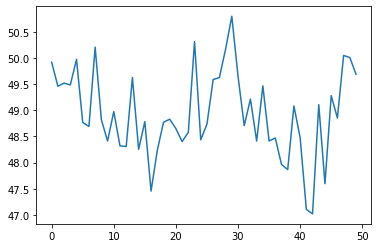

In [21]:
y_single, x_single = simulate(N, a_single, v_single, eta_single, w_single, group_single, beta_single)
plt.plot(range(N), y_single[:, 0])

In [39]:
init_x = np.array([0])
init_c = np.array([1])

(state, state_cov, state_one_step, state_cov_one_step, R_vec, R_inv, y_est, error, neglik, R_cond) = Gibbs.KalmanFilter(y_single, np.identity(1), eta_single, w_single,F_single, a_single, v_single, init_x, init_c )

# pykalman
from pykalman import KalmanFilter
kf = KalmanFilter(transition_matrices = [[1]], observation_matrices = [[1]], transition_covariance=w_single, observation_covariance= v_single, observation_offsets= a_single, initial_state_mean = 0)
(filtered_state_means, filtered_state_covariances) = kf.filter(y_single)
smooth_single, smooth_cov_single = Gibbs.KalmanSmooth(state, state_one_step, state_cov, state_cov_one_step, np.identity(1), eta_single, w_single)
(smoothed_state_means, smoothed_state_covariances) = kf.smooth(y_single)

Let's compare the Kalman Filter with the original data set

In [33]:
np.insert(filtered_state_means,0,0)

array([ 0.        , -0.05329448, -0.35632824, -0.43201029, -0.48280688,
       -0.20037209, -0.83723022, -1.1289863 , -0.30171375, -0.84516115,
       -1.30307895, -1.13006718, -1.47053807, -1.60751728, -0.84396688,
       -1.40099245, -1.28667433, -2.06538966, -1.88306625, -1.47908153,
       -1.2879038 , -1.32627618, -1.49393408, -1.4489512 , -0.35882249,
       -1.10393471, -1.20282649, -0.71275973, -0.50289483, -0.08607876,
        0.4624186 , -0.03584732, -0.8126274 , -0.79535794, -1.28558299,
       -0.81964619, -1.29353137, -1.43921082, -1.80799756, -2.00936366,
       -1.33397968, -1.44950984, -2.34289287, -2.73855132, -1.5975587 ,
       -2.09664987, -1.24557079, -1.18443875, -0.42113582, -0.15383405,
       -0.25012063])

Text(0.5, 1.0, 'The Observations')

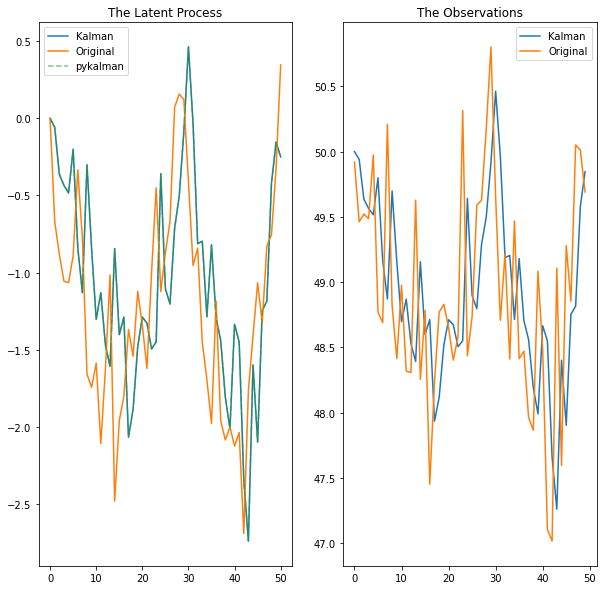

In [37]:
fig, ax = plt.subplots(1,2, figsize = (10, 10))
ax[0].plot(range(N+1), state[:, 0], label = 'Kalman')
ax[0].plot(range(N+1), x_single[:, 0], label = 'Original')
ax[0].plot(range(N+1), np.insert(filtered_state_means,0,0), label = 'pykalman', alpha = 0.6, linestyle='dashed')
ax[0].set_title('The Latent Process')
ax[0].legend()
ax[1].plot(range(N), y_est[:,0], label = 'Kalman')
ax[1].plot(range(N), y_single[:,0], label = 'Original')
ax[1].legend()
ax[1].set_title('The Observations')

Let's look at the smoothing algorithm

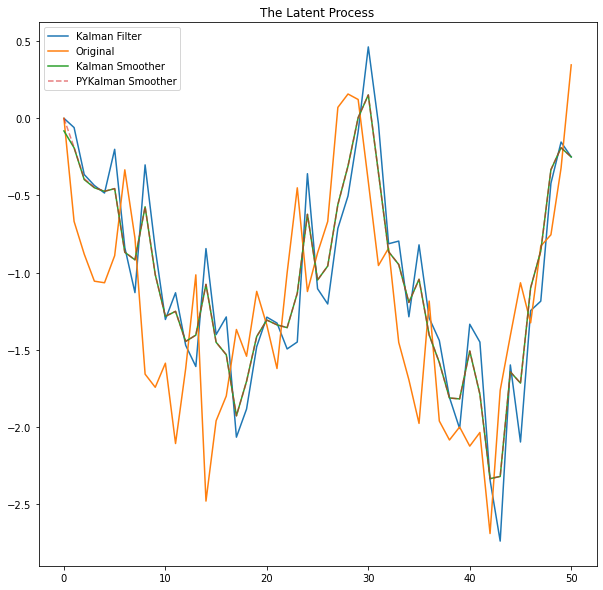

In [42]:
fig, ax = plt.subplots(1,1, figsize = (10, 10))
ax.plot(range(N+1), state[:, 0], label = 'Kalman Filter')
ax.plot(range(N+1), x_single[:, 0], label = 'Original')
ax.plot(range(N+1), smooth_single[:, 0], label = 'Kalman Smoother')
ax.plot(range(N+1), np.insert(smoothed_state_means,0,0), label = 'PYKalman Smoother', alpha = 0.6,  linestyle='dashed')
ax.set_title('The Latent Process')
ax.legend()

Now Let's try and estimate the parameters with a Gibbs Sampler

Let's initiate the sampler

In [ ]:
## Inital parameters and prior specification
init_params = dict()

# init prior

# each beta follows a normal distribution
init_params['beta_mean'] = 1.0/N
init_params['beta_var'] = 0.1

# each alpha follows a normal distribution
init_params['alpha_mean'] = np.array([np.nanmean(y_single)] * 1 )
init_params['alpha_var'] = np.array([2.0] * 1) 

# each eta follows a normal distribution
init_params['eta_mean'] = np.array([0.0] * 1)
init_params['eta_var'] = np.array([1.0] * 1)

# each v follows an inverse gamma
init_params['v_alpha'] = 4
init_params['v_beta'] = 1

# each w follows an inverse gamma
init_params['w_alpha'] = 4
init_params['w_beta'] = 1

# init gibbs
init_params['beta_init'] = np.array([0.1] * 1)
init_params['alpha_init'] = np.nanmean(y_single, axis = 0)
init_params['eta_init'] = 0.0 * np.ones(1) 
init_params['w_init'] =  1.0 * np.ones(1) 
init_params['v_init'] = 1.0 * np.ones(1) 

# init kalman
init_params['init_x'] = np.array([0.0] * (1))
init_params['init_c'] = np.identity((1)) * 100




NameError: name 'N' is not defined

In [ ]:
w_gibbs_single, v_gibbs_single, beta_gibbs_single, A_gibbs_single, B_gibbs_single, states_gibbs_single = lc_single(500, y_single, init_params, verbose = True)

100%|██████████| 500/500 [00:03<00:00, 134.27it/s]


Text(0.5, 1.0, 'variance_x, x= 0')

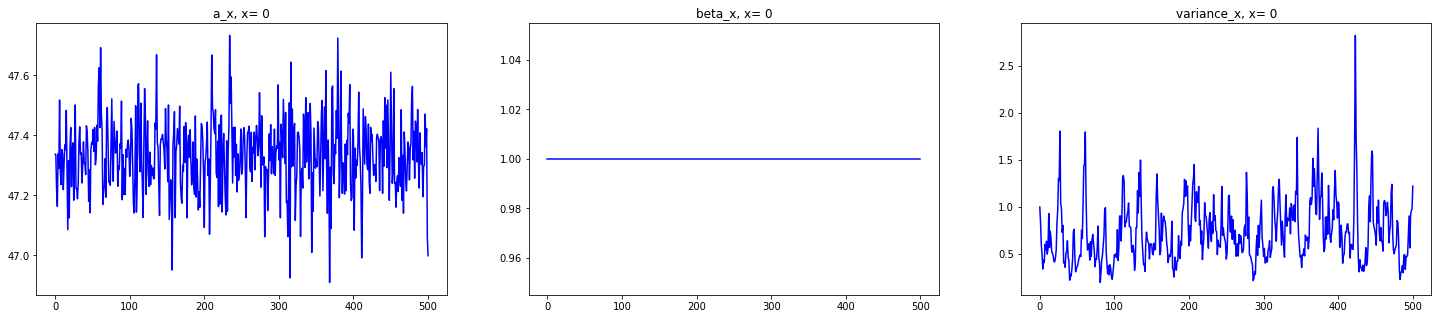

In [ ]:
index = 0
# print(f'a_x = {A_vec_lc_s[index]}, beta_i = {beta_vec_lc_s[index]}, v = {v_lc_s[index]}')

fig, ax = plt.subplots(1,3, figsize = (25,5))
ax[0].plot(range(A_gibbs_single.shape[0]),A_gibbs_single[:,index], color='b')
ax[0].set_title(f'a_x, x= {index}')
ax[1].plot(range(beta_gibbs_single.shape[0]),beta_gibbs_single[:,index], color='b')
ax[1].set_title(f'beta_x, x= {index}')
ax[2].plot(range(v_gibbs_single.shape[0]),v_gibbs_single[:,index], color='b')
ax[2].set_title(f'variance_x, x= {index}')

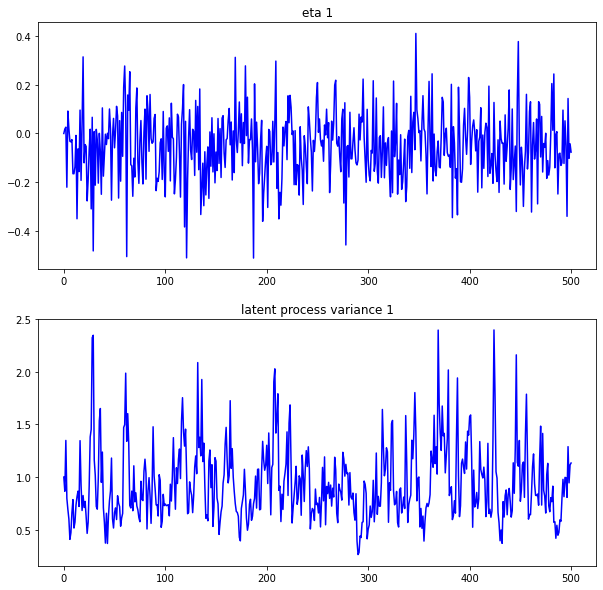

In [ ]:
fig, ax = plt.subplots(2,1, figsize = (10,10))
for j in range(1):
        ax[0].plot(range(B_gibbs_single.shape[0]),B_gibbs_single[:,j], color='b')
        ax[0].set_title(f'eta {j+1}')
        ax[1].plot(range(w_gibbs_single.shape[0]),w_gibbs_single[:,j], color='b')
        ax[1].set_title(f'latent process variance {j+1}')

Text(0.5, 1.0, 'Latent processes')

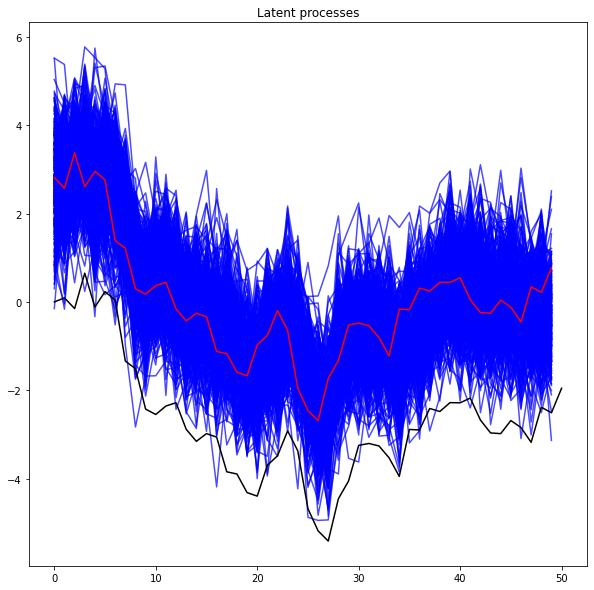

In [ ]:

plt.figure(figsize=(10,10))
for i in range(states_gibbs_single.shape[0]):
    plt.plot(range(states_gibbs_single.shape[1]), states_gibbs_single[i, :, 0], color = 'blue', alpha =0.7, label = 'FFBS')

plt.plot(range(x_single.shape[0]), x_single[:,0], color = 'black', label = 'original')

x_single_constrained = x_single[1:] - np.mean(x_single[1:] , axis = 0)
plt.plot(range(x_single_constrained.shape[0]), x_single_constrained[:,0], color = 'red', label = 'original Constraint')

#plt.legend()
plt.title("Latent processes")

To comment on this: The The constraint latent process will always be withing the FFBS samples if $b_i = 1$ (The real value is actually 1). However, if the real value is not $1$ then the sampler sets it as $1$ and the latent process will have a different magnitude then the original latent process.

# More dimensions no grouping

Here we will consider the case when $p>1$ but $b_i^s = 0, \quad \forall i$

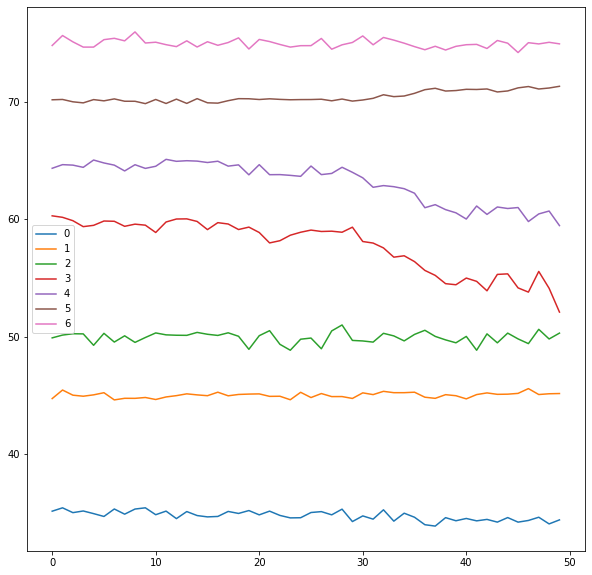

In [ ]:
eta_multi = np.expand_dims(np.array([-0.1]), axis = 1)
w_multi = np.expand_dims(np.array([0.5]), axis = 1)
beta_multi = np.expand_dims([0.1, -0.02, 0.01,  1, 0.8, -0.2, 0], axis = 1)
a_multi = [35, 45, 50, 60, 65, 70, 75]
N = 50
v_multi = [0.3, 0.2, 0.5, 0.4, 0.3, 0.1, 0.3]
group_multi = [0, 0, 0, 0, 0, 0]

F_multi = np.array(beta_multi)

y_multi, x_multi = simulate(N, a_multi, v_multi, eta_multi, w_multi, group_multi, beta_multi)

fig, ax = plt.subplots(1, 1, figsize = (10, 10))
for j in range(len(a_multi)):
    ax.plot(range(N), y_multi[:, j], label = j)

ax.legend()

We start by running a filter

In [ ]:
init_x = np.array([0])
init_c = np.array([10])

(state_multi, 
state_cov_multi, 
state_one_step_multi, 
state_cov_one_step_multi, 
R_inv,
y_est_multi, 
error_multi,
neglik_multi) = KalmanFilter(y_multi, np.identity(1), eta_multi, w_multi, F_multi, a_multi, np.diag(v_multi), init_x, init_c )

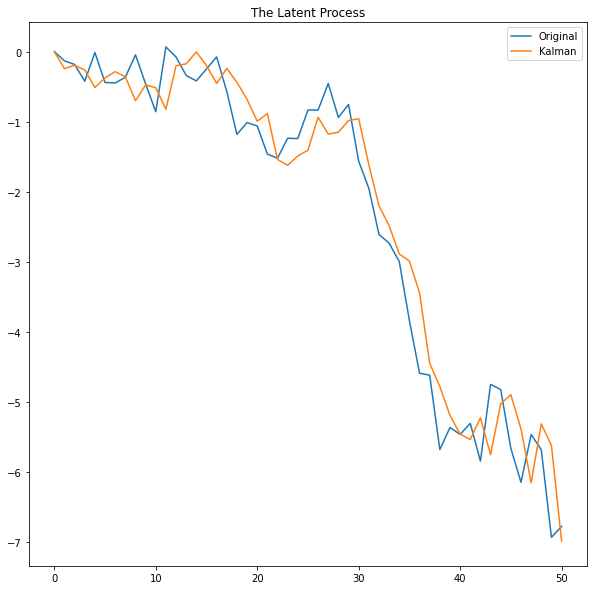

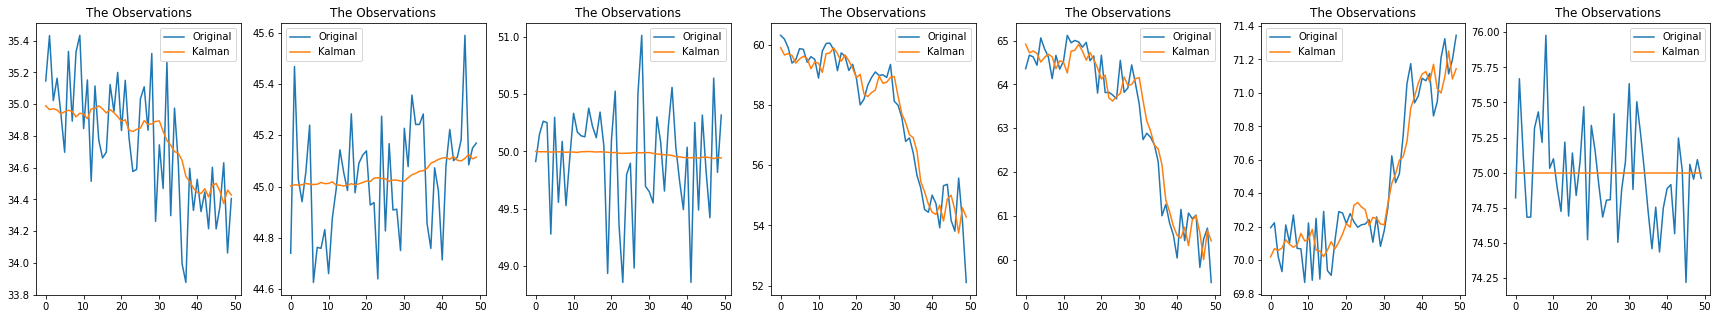

In [ ]:

fig, ax = plt.subplots(1,1, figsize = (10, 10))

ax.plot(range(N+1), x_multi[:, 0], label = 'Original')
ax.plot(range(N+1), state_multi[:, 0], label = 'Kalman')
ax.set_title('The Latent Process')
ax.legend()

fig, ax = plt.subplots(1,len(a_multi), figsize = (30, 5))

for j in range(len(a_multi)):
    ax[j].plot(range(N), y_multi[:,j], label = 'Original')
    ax[j].plot(range(N), y_est_multi[:,j], label = 'Kalman')
    ax[j].legend()
    ax[j].set_title('The Observations')

The one one the right has $\beta_i = 0$ and thus the Kalman filter is just $a_i$

 Let's Try a smoother

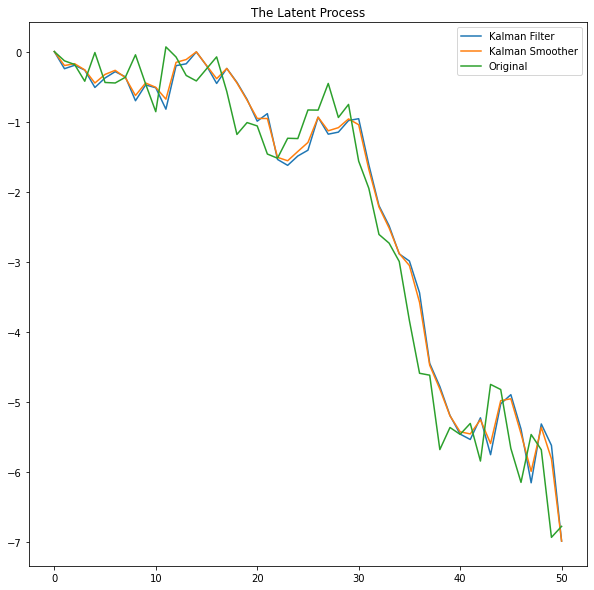

In [ ]:
smooth_multi, smooth_cov_multi = KalmanSmooth(state_multi, state_one_step_multi, state_cov_multi, state_cov_one_step_multi, np.identity(1), eta_multi, w_multi)

fig, ax = plt.subplots(1,1, figsize = (10, 10))
ax.plot(range(N+1), state_multi[:, 0], label = 'Kalman Filter')
ax.plot(range(N+1), smooth_multi[:, 0], label = 'Kalman Smoother')
ax.plot(range(N+1), x_multi[:, 0], label = 'Original')
ax.set_title('The Latent Process')
ax.legend()

Finally we test the Gibbs sampler

In [ ]:
## Inital parameters and prior specification
init_params = dict()
p = len(a_multi)

# init prior

# each beta follows a normal distribution
init_params['beta_mean'] = 0
init_params['beta_var'] = 0.1

# each alpha follows a normal distribution
init_params['alpha_mean'] = np.array(np.nanmean(y_multi, axis = 0) )
init_params['alpha_var'] = np.array([2.0] * p) 

# each eta follows a normal distribution
init_params['eta_mean'] = np.array([0.0] * 1)
init_params['eta_var'] = np.array([1.0] * 1)

# each v follows an inverse gamma
init_params['v_alpha'] = 2.1
init_params['v_beta'] = 2.1

# each w follows an inverse gamma
init_params['w_alpha'] = 4
init_params['w_beta'] = 1

# init gibbs
init_params['beta_init'] = np.array([0.1] * p)
init_params['alpha_init'] = np.nanmean(y_multi, axis = 0)
init_params['eta_init'] = 0.0 * np.ones(1) 
init_params['w_init'] =  1.0 * np.ones(1) 
init_params['v_init'] = 0.5 * np.ones(p) 

# init kalman
init_params['init_x'] = np.array([0.0] * 1)
init_params['init_c'] = np.identity((1)) * 10



In [ ]:
w_gibbs_multi, v_gibbs_multi, beta_gibbs_multi, A_gibbs_multi, B_gibbs_multi, states_gibbs_multi = lc_single(500, y_multi, init_params, verbose = True)

100%|██████████| 500/500 [00:05<00:00, 84.24it/s]


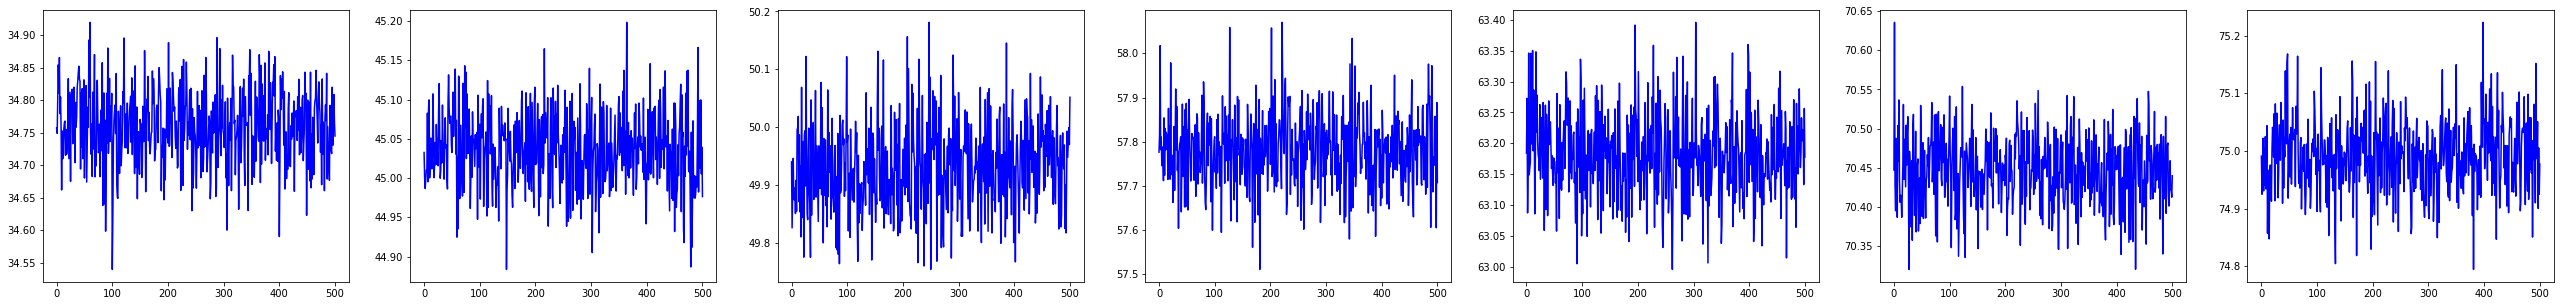

In [ ]:
# print(f'a_x = {A_vec_lc_s[index]}, beta_i = {beta_vec_lc_s[index]}, v = {v_lc_s[index]}')

fig, ax = plt.subplots(1,len(a_multi), figsize = (45,5))
for j in range(len(a_multi)):
    ax[j].plot(range(A_gibbs_multi.shape[0]),A_gibbs_multi[:,j], color='b')

[[ 0.1 ]
 [-0.02]
 [ 0.01]
 [ 1.  ]
 [ 0.8 ]
 [-0.2 ]
 [ 0.  ]]


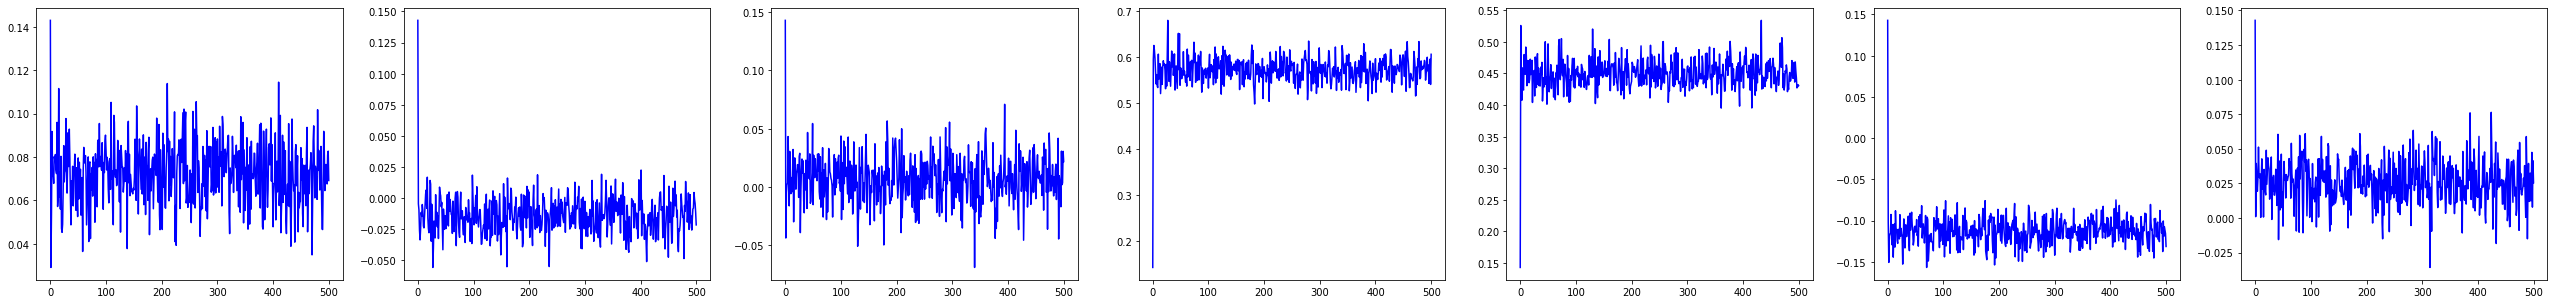

In [ ]:

print(beta_multi)
fig, ax = plt.subplots(1,len(a_multi), figsize = (45,5))
for j in range(len(a_multi)):
    ax[j].plot(range(beta_gibbs_multi.shape[0]),beta_gibbs_multi[:,j], color='b')

[35, 45, 50, 60, 65, 70, 75]


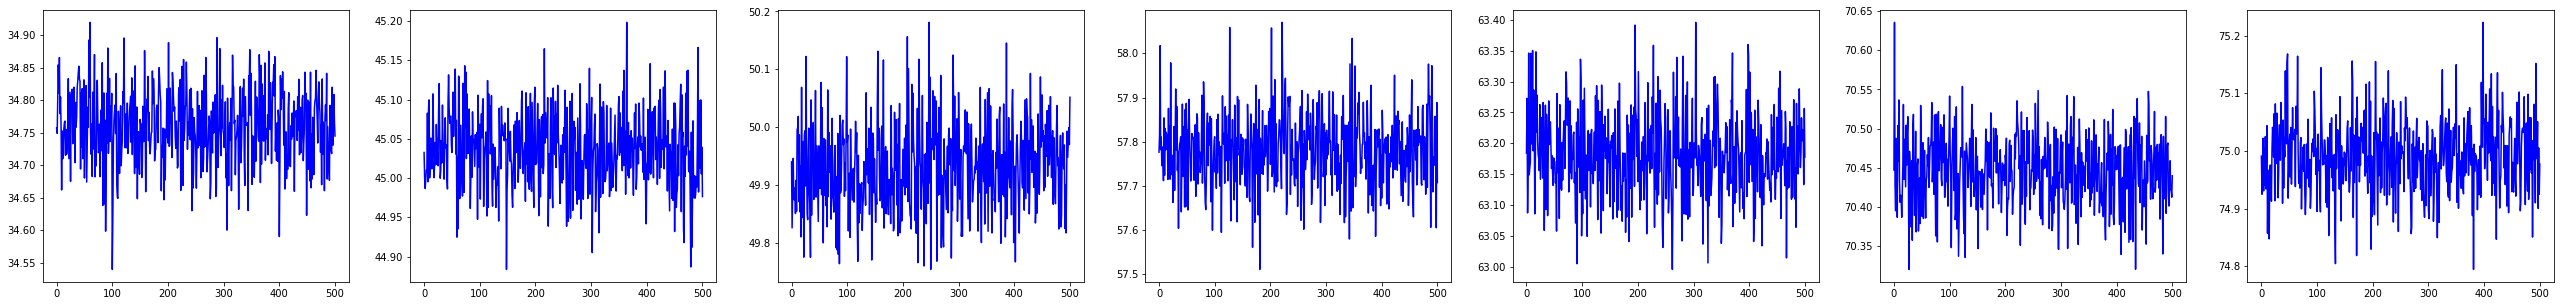

In [ ]:

print(a_multi)
fig, ax = plt.subplots(1,len(a_multi), figsize = (45,5))
for j in range(len(a_multi)):
    ax[j].plot(range(A_gibbs_multi.shape[0]),A_gibbs_multi[:,j], color='b')

[0.3, 0.2, 0.5, 0.4, 0.3, 0.1, 0.3]


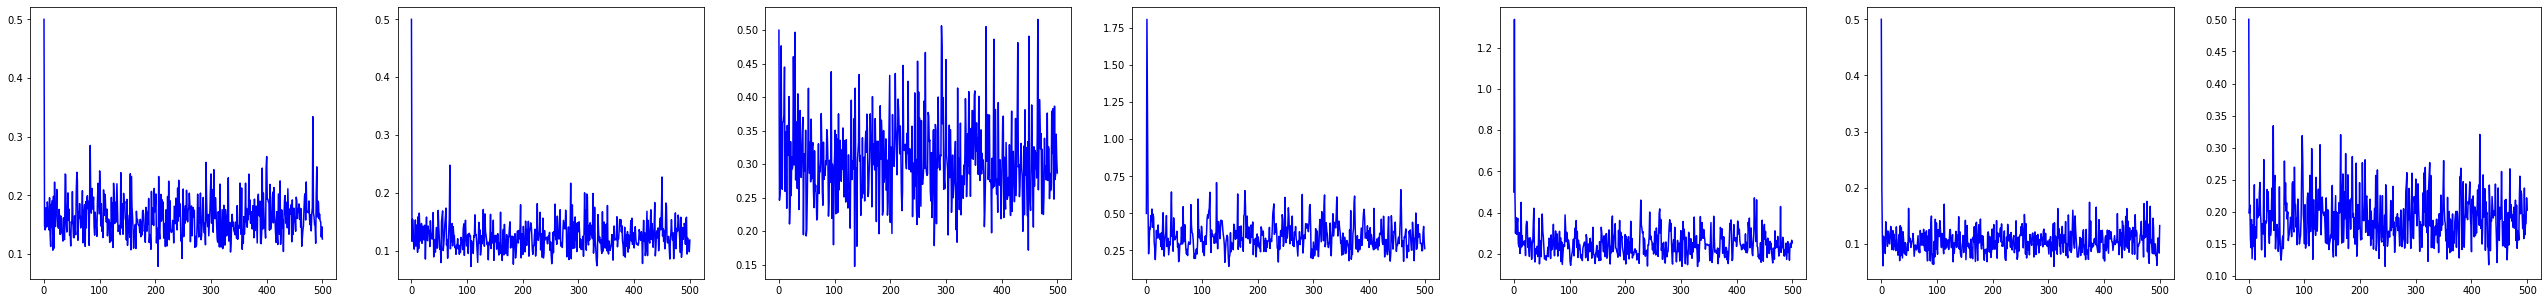

In [ ]:

print(v_multi)
fig, ax = plt.subplots(1,len(a_multi), figsize = (45,5))
for j in range(len(a_multi)):
    ax[j].plot(range(v_gibbs_multi.shape[0]),v_gibbs_multi[:,j], color='b')

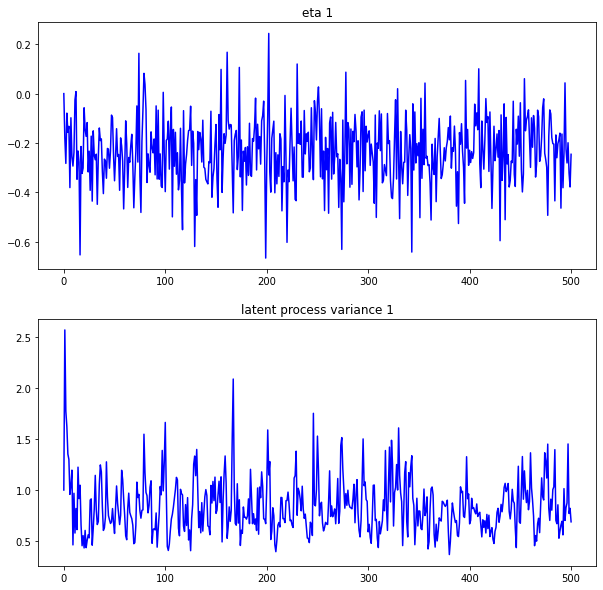

In [ ]:

fig, ax = plt.subplots(2,1, figsize = (10,10))
for j in range(1):
        ax[0].plot(range(B_gibbs_multi.shape[0]),B_gibbs_multi[:,j], color='b')
        ax[0].set_title(f'eta {j+1}')
        ax[1].plot(range(w_gibbs_multi.shape[0]),w_gibbs_multi[:,j], color='b')
        ax[1].set_title(f'latent process variance {j+1}')

Text(0.5, 1.0, 'Latent processes')

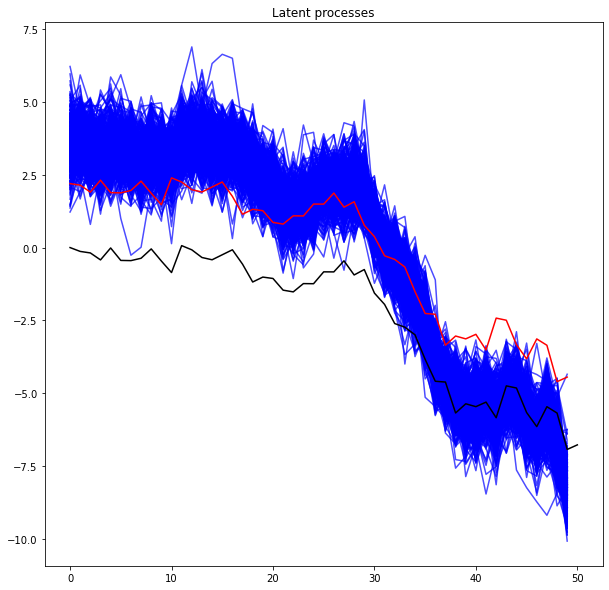

In [ ]:

plt.figure(figsize=(10,10))
for i in range(states_gibbs_multi.shape[0]):
    plt.plot(range(states_gibbs_multi.shape[1]), states_gibbs_multi[i, :, 0], color = 'blue', alpha =0.7, label = 'FFBS')

plt.plot(range(x_multi.shape[0]), x_multi[:,0], color = 'black', label = 'original')

x_multi_constrained = x_multi[1:] - np.mean(x_multi[1:] , axis = 0)
plt.plot(range(x_multi_constrained.shape[0]), x_multi_constrained[:,0], color = 'red', label = 'original Constraint')

#plt.legend()
plt.title("Latent processes")

# ESG univariate modelling

In [43]:
PRICE = pd.read_csv("../Yahoo/YAHOO_PRICE.csv")
ESG_data = pd.read_excel("../Yahoo/YAHOO_PRICE_ESG.xlsx", sheet_name= 'ESG')
TICKERS = np.unique(ESG_data['ticker'])
companies = np.unique(PRICE['ticker']) 


esg_series = ESG_data.copy()  #ESG_data.loc[ESG_data['ticker'] == 'BMY'].copy()
esg_series['timestamp'] = pd.to_datetime(esg_series['timestamp'])
min_date = np.min(ESG_data['timestamp'])
max_date = np.max(ESG_data['timestamp'])
esg_series['date'] = esg_series['timestamp'].dt.date
print(min_date)
print(max_date)
esg_series


# Create a series of days, which will then be joined with esg_series, To create "daily" ESG.
dates = pd.DataFrame({'date':pd.date_range(min_date,max_date,freq='d')})
dates['date'] = dates['date'].dt.date

# create an esg data frame where index is monthly
esg_pivot = esg_series[['ticker', 'esgScore', 'date']].copy()
esg_pivot = pd.pivot_table(esg_pivot, values = 'esgScore', index = 'date', columns= 'ticker')
esg_pivot = pd.merge(dates, esg_pivot, how = 'left', left_on='date', right_index=True)
esg_pivot.set_index('date', inplace= True)
# esg_pivot = esg_pivot.loc[esg_pivot.index <= datetime.date(2019, 11, 1)]


2014-09-01 00:00:00
2021-09-01 00:00:00


Select stock number 

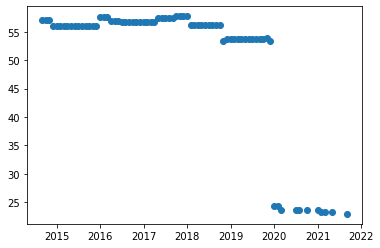

In [81]:
stock_nr = 1
y = np.expand_dims(np.array(esg_pivot['AFL']), axis=1)
plt.scatter(esg_pivot.index, y_obs[:,0])

y_obs = y[:,0, np.newaxis]

Ignore nan

In [84]:
y = y_obs[~np.isnan(y_obs[:,0])]
eta_single = np.expand_dims(np.array([0]), axis = 1)
w_single = np.expand_dims(np.array([4]), axis = 1)
beta_single = np.expand_dims([1], axis = 1)
a_single = np.random.uniform(y[0,0], y[0,0], 1)
N = 50
v_single = np.expand_dims([1], axis = 1)
group_single = [0]

F_single = np.array(beta_single)
init_x = np.array([0])
init_c = np.array([1])

(state, state_cov, state_one_step, state_cov_one_step, R_vec, R_inv, y_est, error, neglik, R_cond) = Gibbs.KalmanFilter(y, np.identity(1), eta_single, w_single,F_single, a_single, v_single, init_x, init_c )

# pykalman
from pykalman import KalmanFilter
kf = KalmanFilter(transition_matrices = [[1]], observation_matrices = [[1]], transition_covariance=w_single, observation_covariance= v_single, observation_offsets= a_single, initial_state_mean = 0)
(filtered_state_means, filtered_state_covariances) = kf.filter(y)
smooth_single, smooth_cov_single = Gibbs.KalmanSmooth(state, state_one_step, state_cov, state_cov_one_step, np.identity(1), eta_single, w_single)
(smoothed_state_means, smoothed_state_covariances) = kf.smooth(y)


Text(0.5, 1.0, 'The Observations')

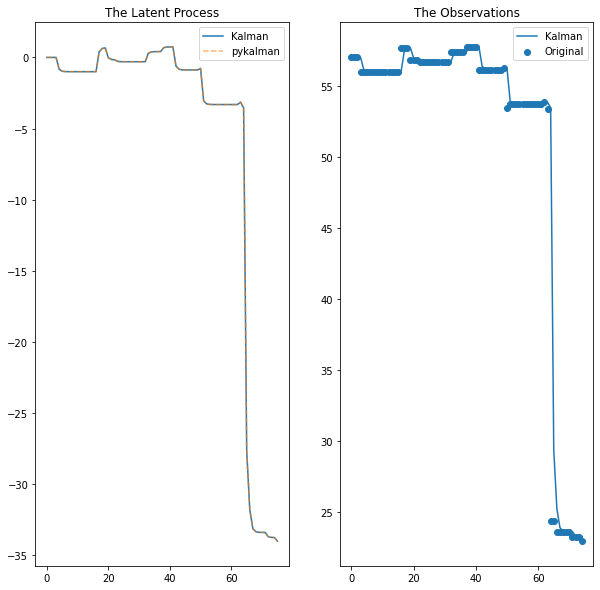

In [85]:
N = len(y[:,0])

fig, ax = plt.subplots(1,2, figsize = (10, 10))
ax[0].plot(range(N+1), state[:, 0], label = 'Kalman')
#ax[0].plot(range(N+1), x_single[:, 0], label = 'Original')
ax[0].plot(range(N+1), np.insert(filtered_state_means,0,0), label = 'pykalman', alpha = 0.6, linestyle='dashed')
ax[0].set_title('The Latent Process')
ax[0].legend()
ax[1].plot(range(N), y_est[:,0], label = 'Kalman')
ax[1].scatter(range(N), y[:,0], label = 'Original')
ax[1].legend()
ax[1].set_title('The Observations')

Find the date of the jump

In [87]:
def find_jump(y):
    """
    Returns
    -------------------------
    jump_index - index when jump occurs
    jump_index_prev - number of observation (nan not included) before jump
    biggest_jump_direction - size of the jump and direction (minus is jump down)


    
    """

    biggest_jump = 0
    biggest_jump_direction = 0
    prev_value = y[0,0]  # previous non nan value
    jump_index = 0
    jump_index_prev = 0

    observations = [0]
    for i in range(1,y.shape[0]):

        if np.isnan(y[i,0]):
            continue

        observations.append(i)


        this_jump = np.abs(y[i,0] - prev_value)
        this_jump_direction = y[i,0] - prev_value
        if this_jump > biggest_jump:
            biggest_jump = this_jump
            biggest_jump_direction = this_jump_direction
            jump_index_prev = observations[-2]
            jump_index = i

        prev_value = y[i,0]

    return jump_index, jump_index_prev, biggest_jump_direction





In [89]:
jump_index, jump_index_prev, biggest_jump_direction = find_jump(y_obs)

# Local Level

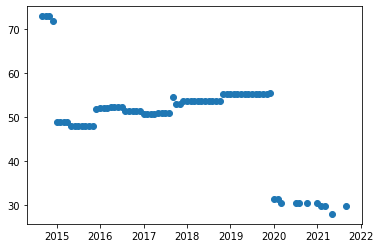

In [45]:
importlib.reload(sys.modules['Gibbs'])
eta = -0.0
w = np.array([0.1])
beta = 1
a = np.zeros((y_obs.shape[0], 1))
a[jump_index:] = biggest_jump_direction
v = np.array([0.1])
group_single = [0]

F = np.array(beta)

init_x = np.array([y_obs[0,0]])
init_c = np.array([0.01])

G = np.array([1])

(state, 
state_cov, 
state_one_step, 
state_cov_one_step, 
R,
R_inv,
y_est, 
error,
neglik_multi,
R_cond) = Gibbs.KalmanFilter(y_obs, G, eta, w, F, a, np.diag(v), init_x, init_c )
plt.scatter(esg_pivot.index, y_obs)

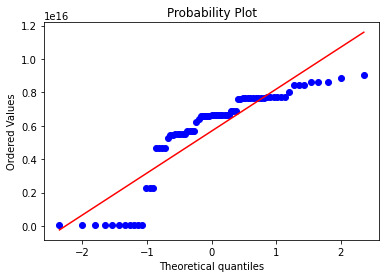

In [59]:
from scipy import stats
xt, _ = stats.boxcox(y_obs[~np.isnan(y_obs[:,0]),0])
fig, ax = plt.subplots(1,1)
prob = stats.probplot(xt, dist=stats.norm, plot=ax)



Text(0.5, 1.0, 'The Observations')

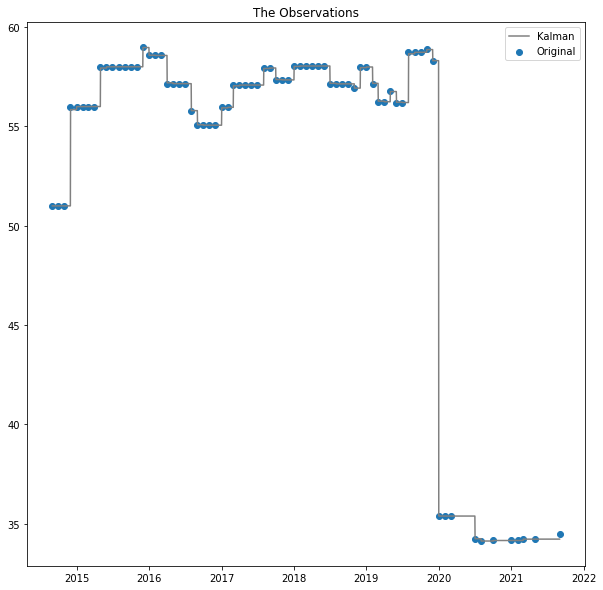

In [65]:
fig, ax = plt.subplots(1,1, figsize = (10, 10))

ax.plot(esg_pivot.index, y_est, label = 'Kalman', color = "grey")
ax.scatter(esg_pivot.index, y_obs, label = 'Original')
ax.legend()
ax.set_title('The Observations')
#ax.set_ylim([60, 75])


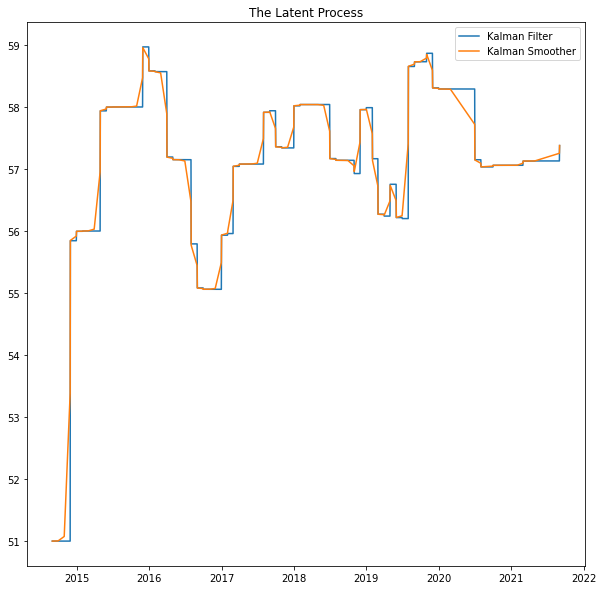

In [64]:
importlib.reload(sys.modules['Gibbs'])
smooth, smooth_cov = Gibbs.KalmanSmooth(state, state_one_step, state_cov, state_cov_one_step, np.identity(1), eta, np.diag(w))
fig, ax = plt.subplots(1,1, figsize = (10, 10))
ax.plot(esg_pivot.index, state[1:, 0], label = 'Kalman Filter')
ax.plot(esg_pivot.index, smooth[1:, 0], label = 'Kalman Smoother')
# ax.plot(esg_pivot.index, smooth_single[1:, 0]  + state_cov_single[1:, 0,0], label = 'Error', alpha = 0.5)
ax.set_title('The Latent Process')
#ax.set_ylim([-15, 5])
ax.legend()

Text(0.5, 1.0, 'The Observations')

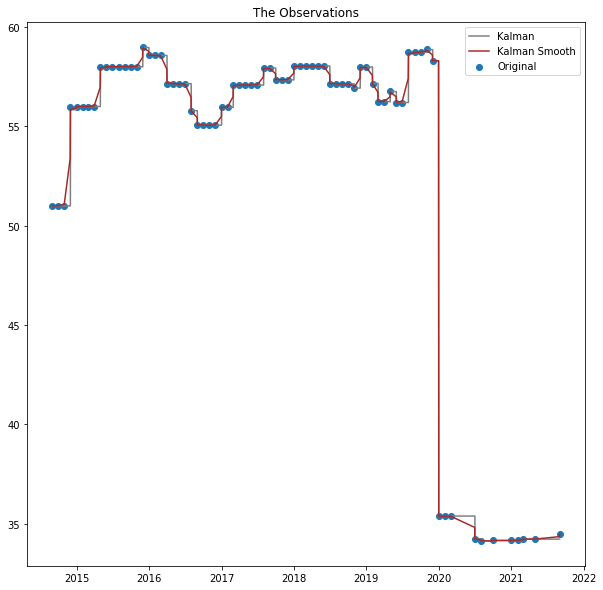

In [67]:

y_est_smooth = np.zeros(y_est.shape[0])
for i in range(y_est.shape[0]):
    y_est_smooth[i] = np.dot(F, smooth[i+1]) + a[i]

fig, ax = plt.subplots(1,1, figsize = (10, 10))

ax.plot(esg_pivot.index, y_est, label = 'Kalman', color = "grey")
ax.plot(esg_pivot.index, y_est_smooth, label = 'Kalman Smooth', color = 'brown')
ax.scatter(esg_pivot.index, y[:,stock_nr], label = 'Original')
ax.legend()
ax.set_title('The Observations')
#ax.set_ylim([60, 75])

Check FFBS

In [68]:
importlib.reload(sys.modules['Gibbs'])
smooth_state_draws, smooth_state, smooth_state_cov, Js, Rs, R_cond = Gibbs.FFBS(y[:,stock_nr, np.newaxis], G, eta, w, F, a,  np.diag(v), init_x, init_c)

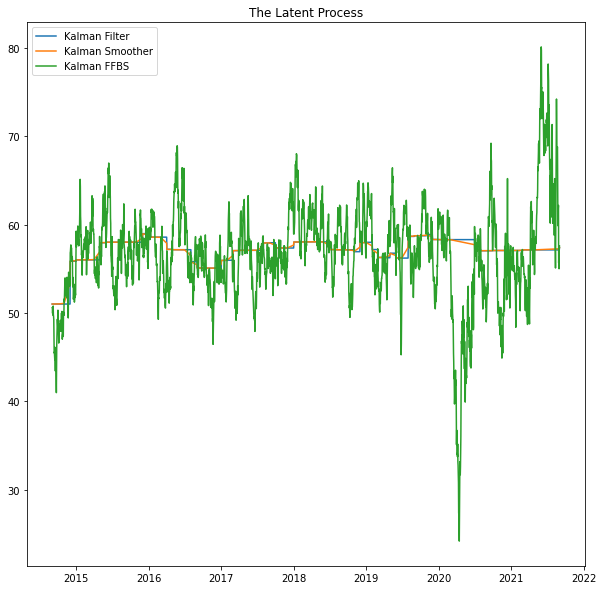

In [69]:
fig, ax = plt.subplots(1,1, figsize = (10, 10))
ax.plot(esg_pivot.index, state[1:, 0], label = 'Kalman Filter')
ax.plot(esg_pivot.index, smooth[1:, 0], label = 'Kalman Smoother')
ax.plot(esg_pivot.index, smooth_state_draws[1:, 0], label = 'Kalman FFBS')
# ax.plot(esg_pivot.index, smooth_single[1:, 0]  + state_cov_single[1:, 0,0], label = 'Error', alpha = 0.5)
ax.set_title('The Latent Process')
#ax.set_ylim([-10, 1])
ax.legend()

Perform Gibbs:

In [90]:
## Inital parameters and prior specification
init_params = dict()

# init prior

# each beta follows a normal distribution
init_params['beta_mean'] = 0
init_params['beta_var'] = 0.1

# each alpha follows a normal distribution
init_params['alpha_mean'] = np.array([biggest_jump_direction] * 1 )
init_params['alpha_var'] = np.array([2.0] * 1) 

# each eta follows a normal distribution
init_params['eta_mean'] = np.array([0.0] * 1)
init_params['eta_var'] = np.array([0.1] * 1)

# each v follows an inverse gamma
init_params['v_alpha'] = 2.1
init_params['v_beta'] = 0.11

# each w follows an inverse gamma
init_params['w_alpha'] = 2.1
init_params['w_beta'] = 0.11

# init gibbs
init_params['beta_init'] = np.array([0.1] * 1)
init_params['alpha_init'] = np.array([biggest_jump_direction] * 1 )
init_params['eta_init'] = 0.0 * np.ones(1) 
init_params['w_init'] =  0.01 * np.ones(1) 
init_params['v_init'] = 0.01 * np.ones(1) 

# init kalman
init_params['init_x'] = np.array([y_obs[0,0]] * (1))
init_params['init_c'] = np.identity((1)) * 0.1

init_params['alpha_init']




array([-28.99])

In [91]:
importlib.reload(sys.modules['Gibbs'])
w_gibbs_single, v_gibbs_single, beta_gibbs_single, A_gibbs_single, B_gibbs_single, states_gibbs_single = Gibbs.local_level(200, y_obs, init_params, shock = (jump_index, jump_index_prev), verbose = True, cov_step_ceiling = 5)

  1%|          | 2/200 [00:00<01:11,  2.78it/s]C:/Users/ragna/Documents/Ragnar/Code/MMDGraph\Gibbs.py:189: RuntimeWarning: covariance is not positive-semidefinite.
  smooth_state_draws[i-1] = np.random.multivariate_normal(smooth_state[i-1], smooth_state_cov[i-1])
100%|██████████| 200/200 [00:53<00:00,  3.77it/s]


Text(0.5, 1.0, 'variance_x, x= 0')

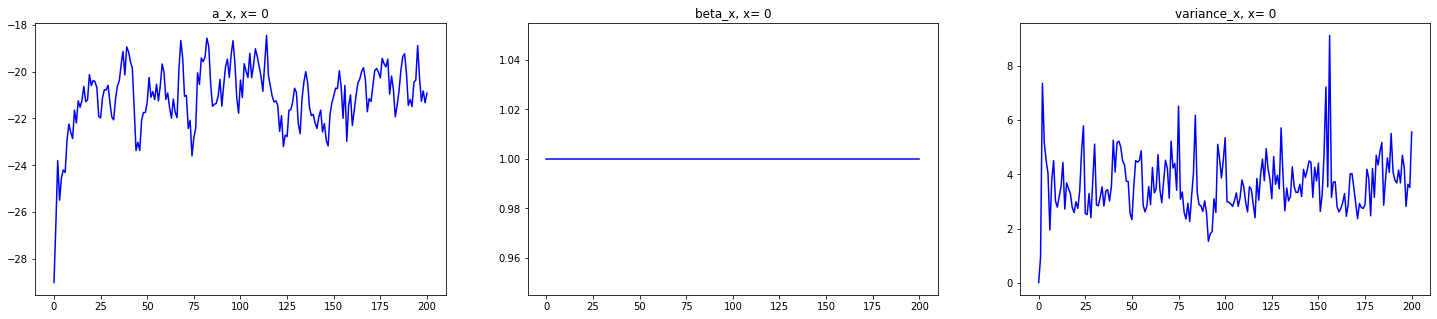

In [92]:
index = 0
# print(f'a_x = {A_vec_lc_s[index]}, beta_i = {beta_vec_lc_s[index]}, v = {v_lc_s[index]}')

fig, ax = plt.subplots(1,3, figsize = (25,5))
ax[0].plot(range(A_gibbs_single.shape[0]),A_gibbs_single[:,index], color='b')
ax[0].set_title(f'a_x, x= {index}')
ax[1].plot(range(beta_gibbs_single.shape[0]),beta_gibbs_single[:,index], color='b')
ax[1].set_title(f'beta_x, x= {index}')
ax[2].plot(range(v_gibbs_single.shape[0]),v_gibbs_single[:,index], color='b')
ax[2].set_title(f'variance_x, x= {index}')

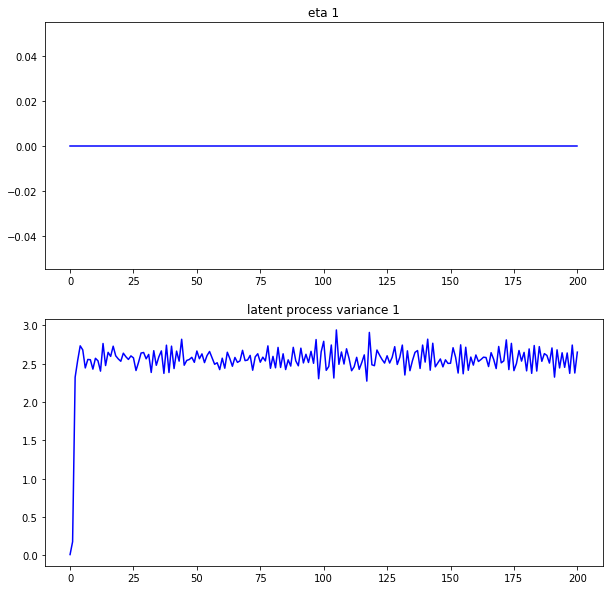

In [93]:


fig, ax = plt.subplots(2,1, figsize = (10,10))
for j in range(1):
        ax[0].plot(range(B_gibbs_single.shape[0]),B_gibbs_single[:,j], color='b')
        ax[0].set_title(f'eta {j+1}')
        ax[1].plot(range(w_gibbs_single.shape[0]),w_gibbs_single[:,j], color='b')
        ax[1].set_title(f'latent process variance {j+1}')


Text(0.5, 1.0, 'Latent processes')

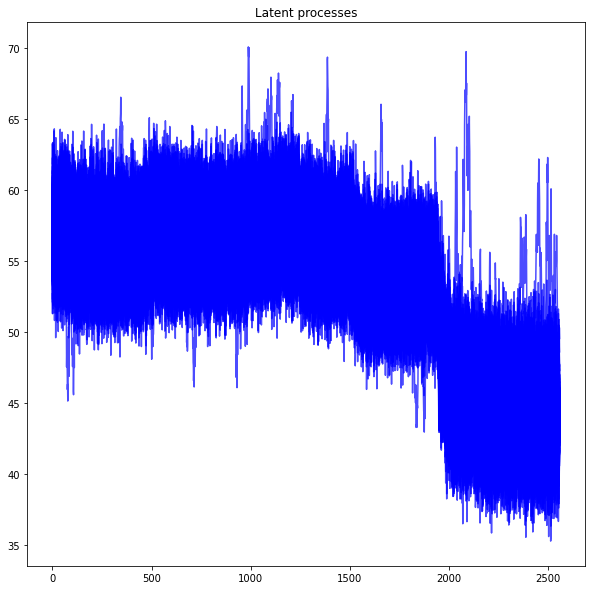

In [94]:

plt.figure(figsize=(10,10))
for i in range(1,states_gibbs_single.shape[0]):
    plt.plot(range(states_gibbs_single.shape[1]), states_gibbs_single[i, :, 0], color = 'blue', alpha =0.7, label = 'FFBS')
#plt.legend()
plt.title("Latent processes")

Estimate the parameters by a median value

In [124]:

importlib.reload(sys.modules['Gibbs'])
eta = np.array([0])
w = np.array([np.median(w_gibbs_single[10:,0])])
beta = np.array(1)
a = np.zeros(y_obs.shape[0])
a[jump_index:] = np.median(A_gibbs_single[10:,0])
v = np.array([np.median(v_gibbs_single[10:,0])])
group_single = [0]

F = np.array(beta)

init_x = np.array([y_obs[0,0]])
init_c = np.array([0.1])

(state, 
state_cov, 
state_one_step, 
state_cov_one_step, 
R,
R_inv,
y_est, 
error,
neglik,
R_cond) = Gibbs.KalmanFilter(y_obs, np.identity(1), eta, w, F, a, v, init_x, init_c )

In [122]:
from numpy import ma
y_ma = ma.asarray(y_obs)
y_ma[np.isnan(y_ma)] = ma.masked
y_ma[30]

masked_array(data=[57.0],
             mask=[False],
       fill_value=1e+20)

Text(0.5, 1.0, 'The Observations')

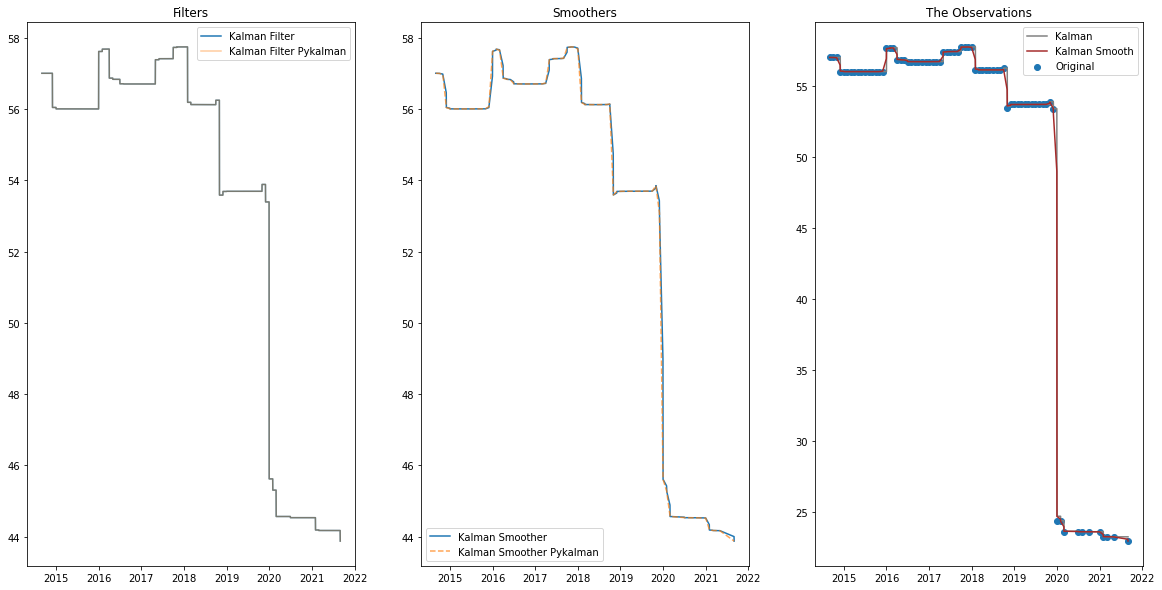

In [129]:
fig, ax = plt.subplots(1,3, figsize = (20, 10))


smooth, smooth_cov= Gibbs.KalmanSmooth(state, state_one_step, state_cov, state_cov_one_step, np.identity(1), eta, w)
from pykalman import KalmanFilter
kf = KalmanFilter(transition_matrices = [1], observation_matrices = [1], transition_covariance=w, observation_covariance= v, observation_offsets= np.expand_dims(a, axis = 1), initial_state_mean = y_obs[0,0])
(filtered_state_means, filtered_state_covariances) = kf.filter(y_ma)
smooth_single, smooth_cov_single = Gibbs.KalmanSmooth(state, state_one_step, state_cov, state_cov_one_step, np.identity(1), eta_single, w_single)
(smoothed_state_means, smoothed_state_covariances) = kf.smooth(y_ma)


ax[0].plot(esg_pivot.index, state[1:, 0], label = 'Kalman Filter')
ax[0].plot(esg_pivot.index, filtered_state_means, label = 'Kalman Filter Pykalman', alpha = 0.7, linestyle = 'dashed')
# ax.plot(esg_pivot.index, smooth_single[1:, 0]  + state_cov_single[1:, 0,0], label = 'Error', alpha = 0.5)
ax[0].set_title('Filters')
#ax.set_ylim([-15, 5])
ax[0].legend()

ax[1].plot(esg_pivot.index, smooth[1:, 0], label = 'Kalman Smoother')
ax[1].plot(esg_pivot.index, smoothed_state_means, label = 'Kalman Smoother Pykalman', alpha = 0.7, linestyle = 'dashed')
ax[1].set_title('Smoothers')
ax[1].legend()

y_est_smooth = np.zeros(y_est.shape[0])
for i in range(y_est.shape[0]):
    y_est_smooth[i] = np.dot(F, smooth[i+1]) + a[i]

ax[2].plot(esg_pivot.index, y_est, label = 'Kalman', color = "grey")
ax[2].plot(esg_pivot.index, y_est_smooth, label = 'Kalman Smooth', color = 'brown')
ax[2].scatter(esg_pivot.index, y_obs[:,0], label = 'Original')
ax[2].legend()
ax[2].set_title('The Observations')

# Local Level For all assets

In [6]:
asset_profiles = pd.read_excel("../Yahoo/YAHOO_PRICE_ESG.xlsx", sheet_name= 'asset_profiles') 

esg_pivot_enough_data = esg_pivot.loc[:,~np.isnan(esg_pivot.iloc[0,:])]
sector_classification = dict()
for company in esg_pivot_enough_data.columns:
    sector_of_company = asset_profiles['sector'].loc[asset_profiles['ticker'] == company].iloc[0]
    if sector_of_company not in sector_classification.keys():
        sector_classification[sector_of_company] = list()
    sector_classification[sector_of_company].append(company)


assert len(sector_classification) == 11

In [7]:
sector_classification.keys()

dict_keys(['Healthcare', 'Industrials', 'Consumer Cyclical', 'Technology', 'Consumer Defensive', 'Utilities', 'Financial Services', 'Basic Materials', 'Real Estate', 'Energy', 'Communication Services'])

In [10]:
import pickle
# Inital parameters and prior specification
init_params = dict()
Gibbs_out = dict() 

Nr_gibbs = 1000

cnt = 0# tech, ut, ind
for stock in np.concatenate((sector_classification['Consumer Cyclical'], 
                                sector_classification['Healthcare'], 
                                sector_classification['Financial Services'],
                                sector_classification['Basic Materials'],
                                sector_classification['Real Estate'],
                                sector_classification['Energy'],
                                sector_classification['Communication Services'],
                                sector_classification['Consumer Defensive'])):
    cnt += 1
    print(f'{stock} {cnt/esg_pivot.shape[1]}')

    if os.path.isfile(f"../data/Gibbs/{stock}.pkl"):
        continue

    # prepare data as numpy array with correct dimension
    y_obs = np.array(esg_pivot[stock])
    y_obs = np.expand_dims(y_obs, axis = 1)

    # find the level_shift
    jump_index, jump_index_prev, biggest_jump_direction = find_jump(y_obs)

    # init prior

    # each beta follows a normal distribution
    init_params['beta_mean'] = 0
    init_params['beta_var'] = 0.1

    # each alpha follows a normal distribution
    init_params['alpha_mean'] = np.array([biggest_jump_direction] * 1 )
    init_params['alpha_var'] = np.array([2.0] * 1) 

    # each eta follows a normal distribution
    init_params['eta_mean'] = np.array([0.0] * 1)
    init_params['eta_var'] = np.array([0.1] * 1)

    # each v follows an inverse gamma
    init_params['v_alpha'] = 2.1
    init_params['v_beta'] = 0.11

    # each w follows an inverse gamma
    init_params['w_alpha'] = 2.1
    init_params['w_beta'] = 0.11

    # init gibbs
    init_params['beta_init'] = np.array([0.1] * 1)
    init_params['alpha_init'] = np.array([biggest_jump_direction] * 1 )
    init_params['eta_init'] = 0.0 * np.ones(1) 
    init_params['w_init'] =  0.01 * np.ones(1) 
    init_params['v_init'] = 0.01 * np.ones(1) 

    # init kalman
    init_params['init_x'] = np.array([y_obs[0,0]] * (1))
    init_params['init_c'] = np.identity((1)) * 0.1

    init_params['alpha_init']
    # Run Kalman
    importlib.reload(sys.modules['Gibbs'])
    w_gibbs, v_gibbs, beta_gibbs, A_gibbs, B_gibbs, states_gibbs = Gibbs.local_level(Nr_gibbs, y_obs, init_params, shock = (jump_index, jump_index_prev), verbose = True, cov_step_ceiling = 3)

    Gibbs_out['w'] = w_gibbs
    Gibbs_out['v'] = v_gibbs
    Gibbs_out['beta'] = beta_gibbs
    Gibbs_out['B_gibbs'] = B_gibbs
    Gibbs_out['A'] = A_gibbs
    Gibbs_out['states'] = states_gibbs

    with open(f'../data/Gibbs/{stock}.pkl', 'wb') as f:
        pickle.dump(Gibbs_out, f)



AAP 0.0035335689045936395
AMZN 0.007067137809187279
APTV 0.01060070671378092
AZO 0.014134275618374558
BBY 0.0176678445229682
BLL 0.02120141342756184
BWA 0.024734982332155476
CCL 0.028268551236749116
CMG 0.03180212014134275
DHI 0.0353356890459364
DRI 0.038869257950530034
EBAY 0.04240282685512368
EXPE 0.045936395759717315
F 0.04946996466431095
FBHS 0.053003533568904596
GM 0.05653710247349823
GPC 0.06007067137809187
GPS 0.0636042402826855
HAS 0.06713780918727916
HBI 0.0706713780918728
HD 0.07420494699646643
IP 0.07773851590106007
KMX 0.0812720848056537
LEG 0.08480565371024736
LEN 0.08833922261484099
LKQ 0.09187279151943463
LOW 0.09540636042402827
LVS 0.0989399293286219
MAR 0.10247349823321555
MCD 0.10600706713780919
A 0.10954063604240283
ABBV 0.11307420494699646
ABC 0.1166077738515901
ABT 0.12014134275618374
AMGN 0.12367491166077739
ANTM 0.127208480565371
BAX 0.13074204946996468
BDX 0.13427561837455831
BIIB 0.13780918727915195
BIO 0.1413427561837456
BMY 0.14487632508833923
BSX 0.148409893

C:/Users/ragna/Documents/Ragnar/Code/MMDGraph\Gibbs.py:189: RuntimeWarning: covariance is not positive-semidefinite.
  smooth_state_draws[i-1] = np.random.multivariate_normal(smooth_state[i-1], smooth_state_cov[i-1])
100%|██████████| 1000/1000 [04:43<00:00,  3.53it/s]


CHD 0.5441696113074205


100%|██████████| 1000/1000 [04:32<00:00,  3.66it/s]


CL 0.5477031802120141


100%|██████████| 1000/1000 [04:28<00:00,  3.72it/s]


CLX 0.5512367491166078


100%|██████████| 1000/1000 [04:42<00:00,  3.54it/s]


COST 0.5547703180212014


100%|██████████| 1000/1000 [04:38<00:00,  3.60it/s]


CPB 0.558303886925795


100%|██████████| 1000/1000 [04:42<00:00,  3.54it/s]


DG 0.5618374558303887


100%|██████████| 1000/1000 [05:01<00:00,  3.31it/s]


DLTR 0.5653710247349824


100%|██████████| 1000/1000 [04:38<00:00,  3.60it/s]


EL 0.568904593639576


100%|██████████| 1000/1000 [04:32<00:00,  3.67it/s]


GIS 0.5724381625441696


100%|██████████| 1000/1000 [04:30<00:00,  3.69it/s]


HRL 0.5759717314487632


100%|██████████| 1000/1000 [04:30<00:00,  3.70it/s]


HSY 0.5795053003533569


100%|██████████| 1000/1000 [04:30<00:00,  3.70it/s]


K 0.5830388692579506


100%|██████████| 1000/1000 [04:27<00:00,  3.73it/s]


KMB 0.5865724381625441


100%|██████████| 1000/1000 [04:34<00:00,  3.64it/s]


KO 0.5901060070671378


100%|██████████| 1000/1000 [04:34<00:00,  3.64it/s]


KR 0.5936395759717314


100%|██████████| 1000/1000 [04:38<00:00,  3.59it/s]


MKC 0.5971731448763251


100%|██████████| 1000/1000 [04:31<00:00,  3.68it/s]


MO 0.6007067137809188


100%|██████████| 1000/1000 [04:33<00:00,  3.66it/s]


SJM 0.6042402826855123


100%|██████████| 1000/1000 [04:29<00:00,  3.71it/s]


STZ 0.607773851590106


100%|██████████| 1000/1000 [04:34<00:00,  3.64it/s]


Read and analyze

In [22]:
stock_name = sector_classification['Technology'][2]
print(stock_name)

y_obs = np.array(esg_pivot[stock_name])
y_obs = np.expand_dims(y_obs, axis = 1)

# find the level_shift
jump_index, jump_index_prev, biggest_jump_direction = find_jump(y_obs)

gibbs_data = pd.read_pickle(f"../data/Gibbs/{stock_name}.pkl")

ADBE


Text(0.5, 1.0, 'variance_x, x= ADBE')

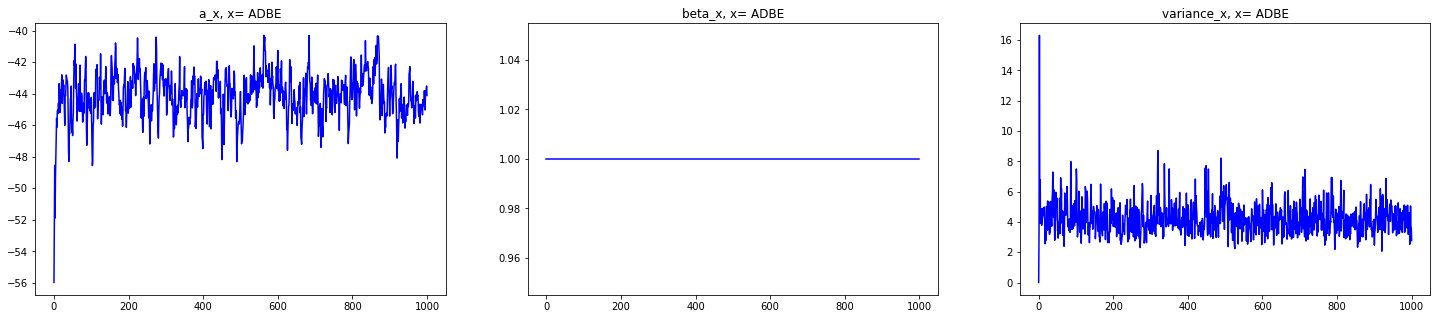

In [23]:
# print(f'a_x = {A_vec_lc_s[index]}, beta_i = {beta_vec_lc_s[index]}, v = {v_lc_s[index]}')

fig, ax = plt.subplots(1,3, figsize = (25,5))
ax[0].plot(range(gibbs_data['A'].shape[0]),gibbs_data['A'][:,0], color='b')
ax[0].set_title(f'a_x, x= {stock_name}')
ax[1].plot(range(gibbs_data['beta'].shape[0]),gibbs_data['beta'][:,0], color='b')
ax[1].set_title(f'beta_x, x= {stock_name}')
ax[2].plot(range(gibbs_data['v'].shape[0]),gibbs_data['v'][:,0], color='b')
ax[2].set_title(f'variance_x, x= {stock_name}')

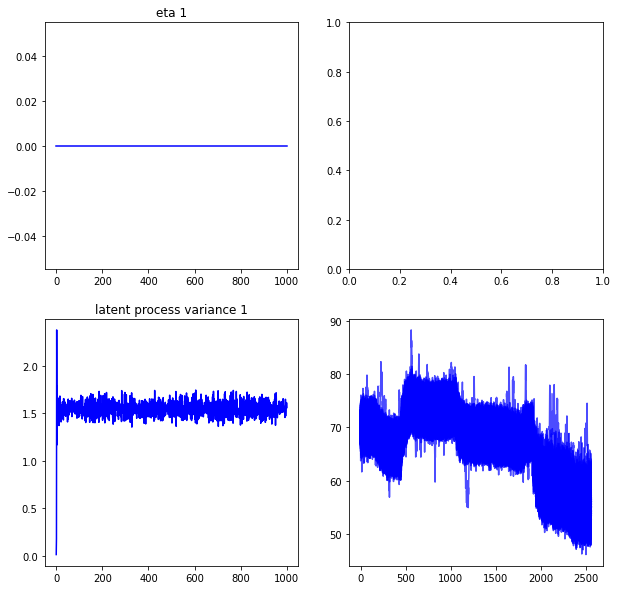

In [24]:
fig, ax = plt.subplots(2,2, figsize = (10,10))
for j in range(1):
        ax[0,0].plot(range(gibbs_data['B_gibbs'].shape[0]),gibbs_data['B_gibbs'][:,0], color='b')
        ax[0,0].set_title(f'eta {j+1}')
        ax[1,0].plot(range(gibbs_data['w'].shape[0]),gibbs_data['w'][:,0], color='b')
        ax[1,0].set_title(f'latent process variance {j+1}')

for i in range(1,gibbs_data['states'].shape[0]):
    ax[1,1].plot(range(gibbs_data['states'].shape[1]), gibbs_data['states'][i, :, 0], color = 'blue', alpha =0.7, label = 'FFBS')


In [26]:


gibbs_data = pd.read_pickle(f"../data/Gibbs/{stock_name}.pkl")
importlib.reload(sys.modules['Gibbs'])
eta = np.array([0])
w = np.array([np.median(gibbs_data['w'][500:,0])])
beta = np.array(1)
a = np.zeros(y_obs.shape[0])
a[jump_index:] = np.median(gibbs_data['A'][500:,0])
v = np.array([np.median(gibbs_data['v'][500:,0])])
group_single = [0]

F = np.array(beta)

init_x = np.array([y_obs[0,0]])
init_c = np.array([0.1])

(state, 
state_cov, 
state_one_step, 
state_cov_one_step, 
R,
R_inv,
y_est, 
error,
neglik,
R_cond) = Gibbs.KalmanFilter(y_obs, np.identity(1), eta, w, F, a, v, init_x, init_c )

Text(0.5, 1.0, 'The Observations')

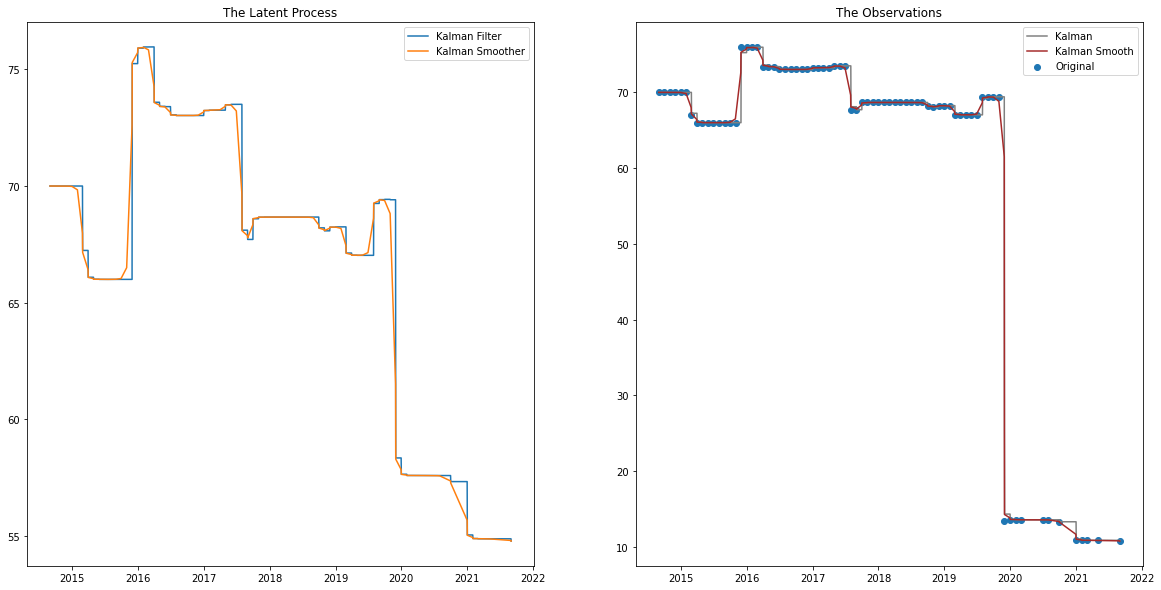

In [27]:
fig, ax = plt.subplots(1,2, figsize = (20, 10))
smooth, smooth_cov= Gibbs.KalmanSmooth(state, state_one_step, state_cov, state_cov_one_step, np.identity(1), eta, w)

ax[0].plot(esg_pivot.index, state[1:, 0], label = 'Kalman Filter')
ax[0].plot(esg_pivot.index, smooth[1:, 0], label = 'Kalman Smoother')
# ax.plot(esg_pivot.index, smooth_single[1:, 0]  + state_cov_single[1:, 0,0], label = 'Error', alpha = 0.5)
ax[0].set_title('The Latent Process')
#ax.set_ylim([-15, 5])
ax[0].legend()


y_est_smooth = np.zeros(y_est.shape[0])
for i in range(y_est.shape[0]):
    y_est_smooth[i] = np.dot(F, smooth[i+1]) + a[i]

ax[1].plot(esg_pivot.index, y_est, label = 'Kalman', color = "grey")
ax[1].plot(esg_pivot.index, y_est_smooth, label = 'Kalman Smooth', color = 'brown')
ax[1].scatter(esg_pivot.index, y_obs[:,0], label = 'Original')
ax[1].legend()
ax[1].set_title('The Observations')

Estimate each stock

In [26]:
import pickle
import tqdm
pbar = tqdm.tqdm(total= len(np.concatenate([sector_classification[s] for s in sector_classification.keys()])))

for stock in np.concatenate([sector_classification[s] for s in sector_classification.keys()]):


    #  Get data
    y_obs = np.array(esg_pivot[stock])
    y_obs = np.expand_dims(y_obs, axis = 1)

    # find the level_shift
    jump_index, jump_index_prev, biggest_jump_direction = find_jump(y_obs)

    # Perform Estimation
    gibbs_data = pd.read_pickle(f"../data/Gibbs/{stock}.pkl")
    importlib.reload(sys.modules['Gibbs'])
    eta = np.array([0])
    w = np.array([np.median(gibbs_data['w'][100:,0])])
    beta = np.array(1)
    a = np.zeros(y_obs.shape[0])
    a[jump_index:] = np.median(gibbs_data['A'][100:,0])
    v = np.array([np.median(gibbs_data['v'][100:,0])])
    group_single = [0]

    F = np.array(beta)

    init_x = np.array([y_obs[0,0]])
    init_c = np.array([0.1])

    (state, 
    state_cov, 
    state_one_step, 
    state_cov_one_step, 
    R,
    R_inv,
    y_est, 
    error,
    neglik,
    R_cond) = Gibbs.KalmanFilter(y_obs, np.identity(1), eta, w, F, a, v, init_x, init_c )

    smooth, smooth_cov= Gibbs.KalmanSmooth(state, state_one_step, state_cov, state_cov_one_step, np.identity(1), eta, w)


    y_est_smooth = np.zeros(y_est.shape[0])
    for i in range(y_est.shape[0]):
        y_est_smooth[i] = np.dot(F, smooth[i+1]) + a[i]
        

    Estimation = {"smooth":smooth, "smooth_cov":smooth_cov, "filter":state, "filter_cov":state_cov, "y_est":y_est, "y_smooth":y_est_smooth, "date":list(esg_pivot.index)}

    # Save    
    with open(f'../data/Gibbs/Estimate/{stock}.pkl', 'wb') as f:
        pickle.dump(Estimation, f)

    pbar.update()

pbar.close()



100%|██████████| 257/257 [00:49<00:00,  5.24it/s]


# Local Level Trend

In [99]:
eta = -0.0
w = np.array([0.01, 0.01])
beta = 1
a = np.array([55])
v = np.array([0.01])
group_single = [0]

F = np.zeros((1,2))
F[0,0] = beta


init_x = np.array([0,0])
init_c = np.ones(2)

G = np.identity(2)
G[0,1] = 1

(state, 
state_cov, 
state_one_step, 
state_cov_one_step, 
R,
R_inv,
y_est, 
error,
neglik_multi,
R_cond) = KalmanFilter(y[:,stock_nr, np.newaxis], G, eta, w, F, a, np.diag(v), init_x, init_c )

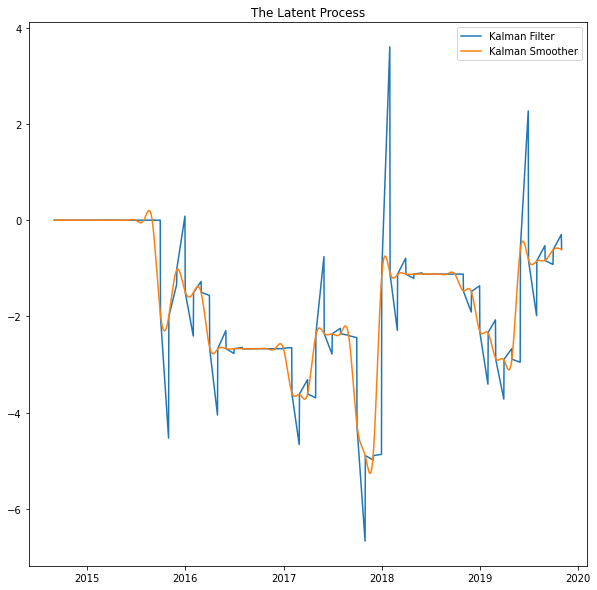

In [92]:

smooth, smooth_cov_ = KalmanSmooth(state, state_one_step, state_cov, state_cov_one_step, G, eta, w)
fig, ax = plt.subplots(1,1, figsize = (10, 10))
ax.plot(esg_pivot.index, state[1:, 0], label = 'Kalman Filter')
ax.plot(esg_pivot.index, smooth[1:, 0], label = 'Kalman Smoother')
# ax.plot(esg_pivot.index, smooth_single[1:, 0]  + state_cov_single[1:, 0,0], label = 'Error', alpha = 0.5)
ax.set_title('The Latent Process')
#ax.set_ylim([-15, 5])
ax.legend()

Text(0.5, 1.0, 'The Observations')

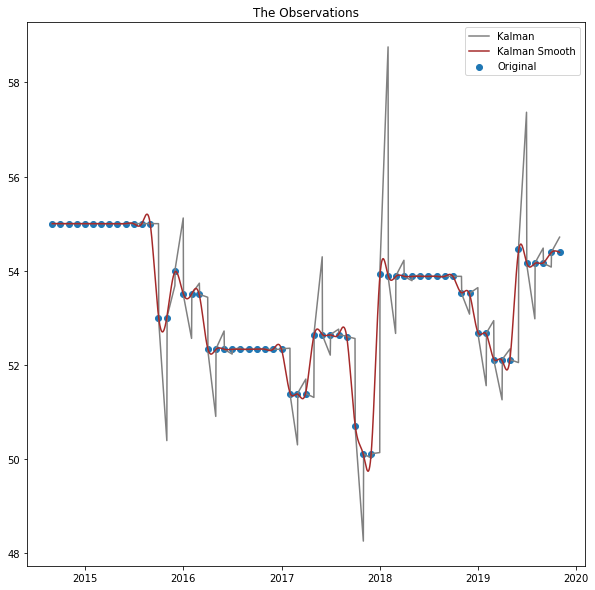

In [100]:

y_est_smooth = np.zeros(y_est.shape[0])
for i in range(y_est.shape[0]):
    y_est_smooth[i] = np.dot(F, smooth[i+1]) + a

fig, ax = plt.subplots(1,1, figsize = (10, 10))

ax.plot(esg_pivot.index, y_est, label = 'Kalman', color = "grey")
ax.plot(esg_pivot.index, y_est_smooth, label = 'Kalman Smooth', color = 'brown')
ax.scatter(esg_pivot.index, y[:,stock_nr], label = 'Original')
ax.legend()
ax.set_title('The Observations')
#ax.set_ylim([60, 75])

In [97]:
y_est

array([[ 0.        ],
       [55.        ],
       [55.        ],
       ...,
       [54.69183004],
       [54.7022386 ],
       [ 0.        ]])

In [84]:
smooth_state_draws, smooth_state, smooth_state_cov, Js, Rs, R_cond = FFBS(y[:,stock_nr, np.newaxis], G, eta, w, F, a,  np.diag(v), init_x, init_c)

C:\Users\ragna\AppData\Local\Temp/ipykernel_2644/2926315325.py:229: RuntimeWarning: covariance is not positive-semidefinite.
  smooth_state_draws[i-1] = np.random.multivariate_normal(smooth_state[i-1], smooth_state_cov[i-1])


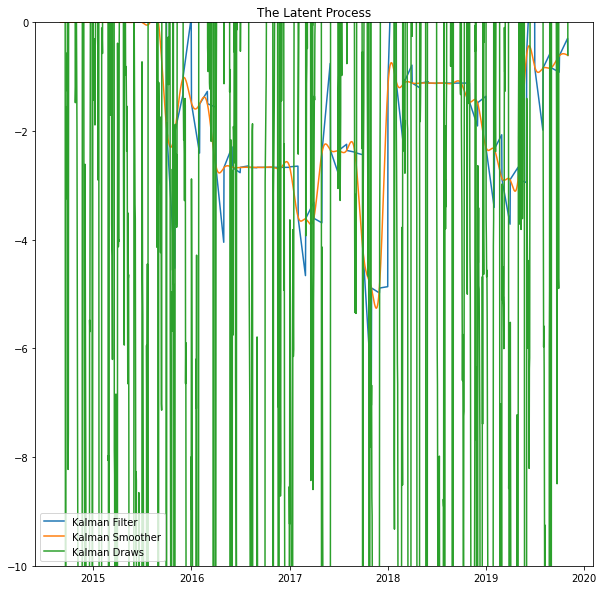

In [88]:
smooth, smooth_cov_ = KalmanSmooth(state, state_one_step, state_cov, state_cov_one_step, G, eta, w)
fig, ax = plt.subplots(1,1, figsize = (10, 10))
ax.plot(esg_pivot.index, state[1:, 0], label = 'Kalman Filter')
ax.plot(esg_pivot.index, smooth[1:, 0], label = 'Kalman Smoother')
ax.plot(esg_pivot.index, smooth_state_draws[1:, 0], label = 'Kalman Draws')
# ax.plot(esg_pivot.index, smooth_single[1:, 0]  + state_cov_single[1:, 0,0], label = 'Error', alpha = 0.5)
ax.set_title('The Latent Process')
ax.set_ylim([-10, 0])
ax.legend()

In [66]:
np.linalg.cond(Rs[-1])

40.21040205582089

In [74]:
state_cov[-2]

array([[168.33894566,   7.10887719],
       [  7.10887719,   0.38194854]])

In [43]:
## Inital parameters and prior specification
init_params = dict()

# init prior

# each beta follows a normal distribution
init_params['beta_mean'] = 0
init_params['beta_var'] = 0.1

# each alpha follows a normal distribution
init_params['alpha_mean'] = np.array([y[0,stock_nr]] * 1 )
init_params['alpha_var'] = np.array([2.0] * 1) 

# each eta follows a normal distribution
init_params['eta_mean'] = np.array([0.0] * 1)
init_params['eta_var'] = np.array([0.1] * 1)

# each v follows an inverse gamma
init_params['v_alpha'] = 2.1
init_params['v_beta'] = 0.11

# each w follows an inverse gamma
init_params['w_alpha'] = np.array([2.1, 2.1])
init_params['w_beta'] = np.array([0.11, 0.11])

# init gibbs
init_params['beta_init'] = np.array([0.1] * 1)
init_params['alpha_init'] = np.array([y[0,stock_nr]] * 1 )
init_params['eta_init'] = 0.0 * np.ones(1) 
init_params['w_init'] =  0.01 * np.ones(1) 
init_params['v_init'] = 0.01 * np.ones(1) 

# init kalman
init_params['init_x'] = np.array([0.0, 0.0] * (1))
init_params['init_c'] = np.identity(2) * 100

init_params['alpha_init']


array([55.])

In [44]:
w_gibbs_single, v_gibbs_single, beta_gibbs_single, A_gibbs_single, B_gibbs_single, states_gibbs_single = local_level_trend(100, y[:,stock_nr, np.newaxis], init_params, verbose = True)

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\ragna\AppData\Local\Temp/ipykernel_2644/2527093916.py:223: RuntimeWarning: covariance is not positive-semidefinite.
  smooth_state_draws[i-1] = np.random.multivariate_normal(smooth_state[i-1], smooth_state_cov[i-1])
100%|██████████| 100/100 [00:28<00:00,  3.55it/s]


Text(0.5, 1.0, 'variance_x, x= 0')

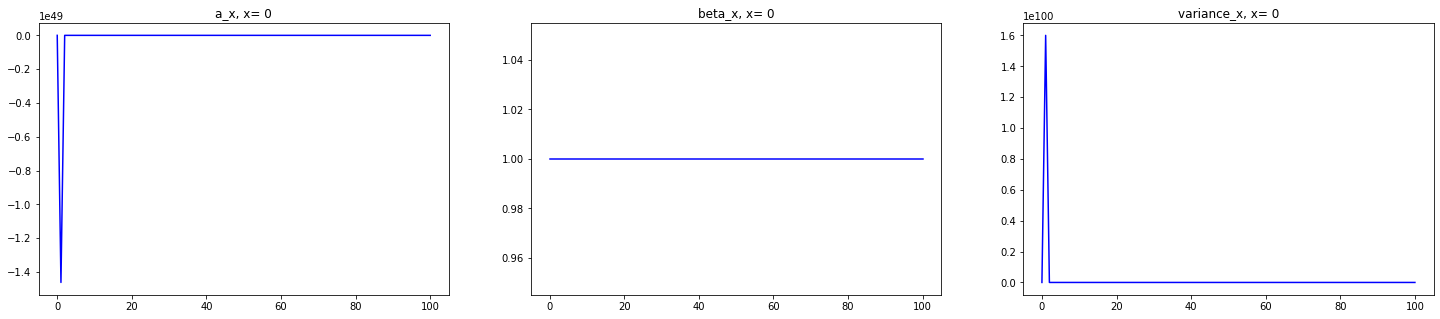

In [45]:
index = 0
# print(f'a_x = {A_vec_lc_s[index]}, beta_i = {beta_vec_lc_s[index]}, v = {v_lc_s[index]}')

fig, ax = plt.subplots(1,3, figsize = (25,5))
ax[0].plot(range(A_gibbs_single.shape[0]),A_gibbs_single[:,index], color='b')
ax[0].set_title(f'a_x, x= {index}')
ax[1].plot(range(beta_gibbs_single.shape[0]),beta_gibbs_single[:,index], color='b')
ax[1].set_title(f'beta_x, x= {index}')
ax[2].plot(range(v_gibbs_single.shape[0]),v_gibbs_single[:,index], color='b')
ax[2].set_title(f'variance_x, x= {index}')

# Multiple stocks with Grouping

In [604]:
nr_groups_multi_g = 2
nr_stocks_multi_g = 10
np.random.seed(42)


eta_multi_g = np.array([-0.1, -0.1, -0.2])
w_multi_g = np.array([0.5, 0.4, 0.2])
beta_multi_g = np.random.uniform(-0.5, 0.5, nr_stocks_multi_g)
beta_s_multi_g = np.random.uniform(-0.5, 0.5, nr_stocks_multi_g)
a_multi_g =  np.random.uniform(40, 70, nr_stocks_multi_g)
N = 50
v_multi_g = np.random.uniform(0.2, 0.5, nr_stocks_multi_g)
group_multi_g = [0] * 5 + [1] * 5


F_multi_g = np.zeros((nr_stocks_multi_g, 1 + nr_groups_multi_g))
F_multi_g[:,0] = beta_multi_g
for j in range(F_multi_g.shape[0]):
    F_multi_g[j, group_multi_g[j] +1] = beta_s_multi_g[j]

y_multi_g, x_multi_g = simulate(N, a_multi_g, v_multi_g, eta_multi_g, w_multi_g, group_multi_g, beta_multi_g, beta_s_multi_g)

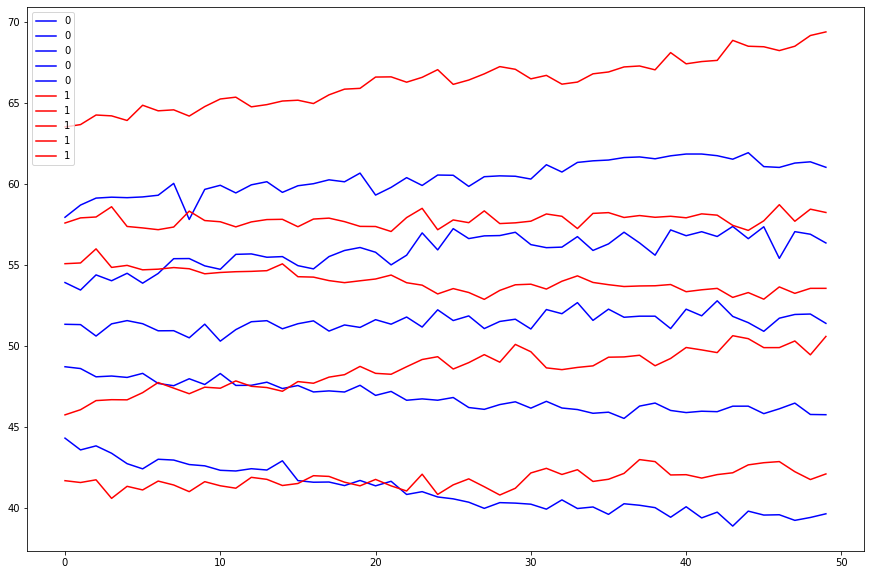

In [309]:



colors = ['blue', 'red']
fig, ax = plt.subplots(1, 1, figsize = (15, 10))
for j in range(len(a_multi_g)):
    ax.plot(range(N), y_multi_g[:, j], label = group_multi_g[j], color = colors[group_multi_g[j]])

ax.legend()

In [310]:
init_x = np.array([0, 0, 0])
init_c = np.array([10, 10, 10])

(state_multi_g, 
state_cov_multi_g, 
state_one_step_multi_g, 
state_cov_one_step_multi_g, 
R_inv_multi_g,
y_est_multi_g, 
error_multi_g,
neglik_multi_g) = KalmanFilter(y_multi_g, np.identity(3), eta_multi_g, np.diag(w_multi_g), F_multi_g, a_multi_g, np.diag(v_multi_g), init_x, init_c )

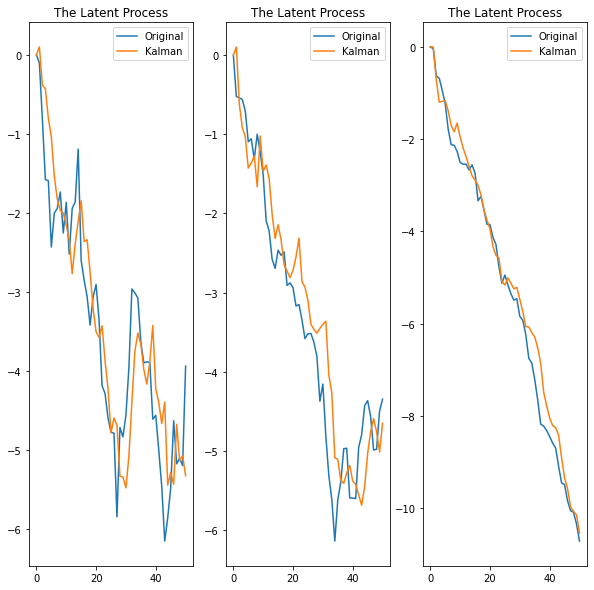

In [311]:


fig, ax = plt.subplots(1,3, figsize = (10, 10))
for j in range(x_multi_g.shape[1]):
    ax[j].plot(range(N+1), x_multi_g[:, j], label = 'Original')
    ax[j].plot(range(N+1), state_multi_g[:, j], label = 'Kalman')
    ax[j].set_title('The Latent Process')
    ax[j].legend()


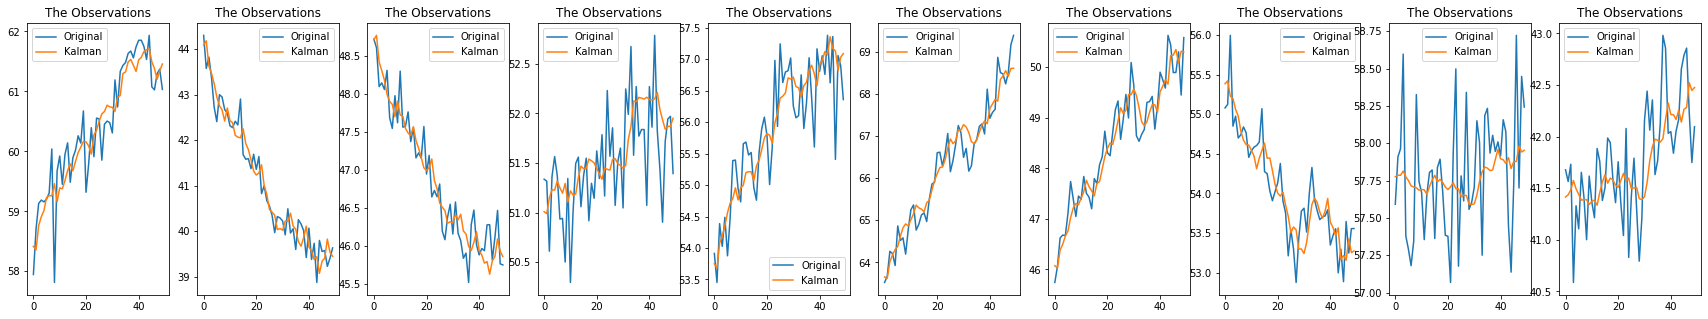

In [533]:
fig, ax = plt.subplots(1,len(a_multi_g), figsize = (30, 5))

for j in range(len(a_multi_g)):
    ax[j].plot(range(N), y_multi_g[:,j], label = 'Original')
    ax[j].plot(range(N), y_est_multi_g[:,j], label = 'Kalman')
    ax[j].legend()
    ax[j].set_title('The Observations')

We can smooth as well

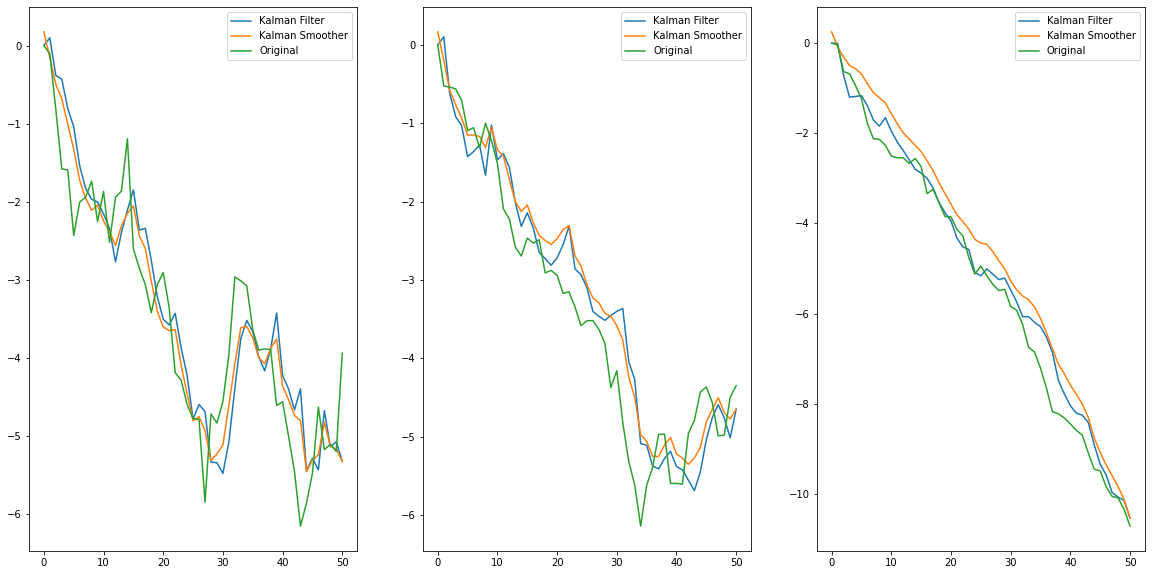

In [312]:
smooth_multi_g, smooth_cov_multi_g = KalmanSmooth(state_multi_g, state_one_step_multi_g, state_cov_multi_g, state_cov_one_step_multi_g, np.identity(3), eta_multi_g, np.diag(w_multi_g))

fig, ax = plt.subplots(1,3, figsize = (20, 10))
for j in range(x_multi_g.shape[1]):
    ax[j].plot(range(N+1), state_multi_g[:, j], label = 'Kalman Filter')
    ax[j].plot(range(N+1), smooth_multi_g[:, j], label = 'Kalman Smoother')
    ax[j].plot(range(N+1), x_multi_g[:, j], label = 'Original')
    ax[j].legend()

Important: The smoother has to be regularized in order for the smoother to work. Otherwise, we get a SVD error

Now for the fitting, we have to write another Gibbs sampler

In [625]:
def gibbs_group(N, y, group_membership, init_params, verbose = True ):
    """
    Calculate Kalman Smoother
    y_t = Fx_t + A
    x_t = Gx_{t-1} + B 

    :param N: Number of samples
    :param y: np.array of data n times p
    :param group_membership: a array indicating the group stock i belongs to. The grouping should have the form  0,1,2,3,..,k-1. where k is the number of groups.
    :param init_params: dict with the prior parameters and initial guess 
    """

    n_stock = y.shape[1]
    T = y.shape[0]
    n_groups = len(np.unique(group_membership))

    print(f'T {T}, n_stock {n_stock}, n_groups {n_groups}')

    # Priors
    beta_mean = init_params['beta_mean']
    beta_var = init_params['beta_var']

    alpha_mean = init_params['alpha_mean']
    alpha_var = init_params['alpha_var']

    eta_mean = init_params['eta_mean']
    eta_var = init_params['eta_var']

    v_alpha = init_params['v_alpha']
    v_beta = init_params['v_beta']

    w_alpha = init_params['w_alpha']
    w_beta = init_params['w_beta']

    # initial gibbs
    beta_init = init_params['beta_init']
    alpha_init = init_params['alpha_init']
    eta_init = init_params['eta_init']
    w_init = init_params['w_init']
    v_init = init_params['v_init']

    # init kalman
    init_x = init_params['init_x']
    init_c = init_params['init_c']


    B_vec = np.zeros((N+1,1 + n_groups))
    B_vec[0] = eta_init

    R_conds = np.zeros((N,y.shape[0],2))

    w = np.zeros((N+1,1 + n_groups))
    w[0] = w_init

    beta_vec = np.zeros((N+1,2*n_stock))
    beta_vec[0] = beta_init

    A_vec = np.zeros((N+1,n_stock))
    A_vec[0] = alpha_init

    v = np.zeros((N+1, n_stock))
    v[0] = v_init

    states_store = np.zeros((N, T, 1 + n_groups))

    G = np.identity(1 + n_groups)

    R_cond_all = np.zeros((N, T, 2))


    # index to help count
    index = np.array(range(n_stock))

    # constraints
    beta_vec[0, :n_stock] = beta_vec[0, :n_stock]/np.sum(np.abs(beta_vec[0, :n_stock]))
    for j in group_membership:
        beta_vec[0, n_stock + index[group_membership == j]] = beta_vec[0, n_stock + index[group_membership == j]]/np.sum(np.abs(beta_vec[0, n_stock + index[group_membership == j]]))


    if verbose:
            pbar = tqdm.tqdm(disable=(verbose is False), total= N)

    for i in range(1,N+1):

        F = np.zeros((n_stock,  1+ n_groups))
        F[:,0] = beta_vec[i-1, :n_stock]
        for j in range(n_stock):
            F[j,1 + group_membership[j]] = beta_vec[i-1,n_stock + j]
            

        smooth_state, R_cond = FFBS(y, G, B_vec[i-1], np.diag(w[i-1]), F, A_vec[i-1],  np.diag(v[i-1]), init_x, init_c)
        R_cond_all[i-1] = R_cond

        # Constraint
        smooth_state_new =   smooth_state[1:]  - np.mean(smooth_state[1:] , axis = 0)
        # print(smooth_state_new.shape)
        states_store[i-1] = smooth_state_new

        # sample beta_i
        for j in range(y.shape[1]):
            var = 1.0 / ((np.sum(smooth_state_new[:,0] ** 2) / v[i-1,j]) + (1.0 / beta_var))
            tmp1 = y[:,j]*smooth_state_new[:,0]
            tmp2 = A_vec[i-1, j]*smooth_state_new[:,0] 
            tmp3 = beta_vec[i-1, n_stock + j]*smooth_state_new[:,0]*smooth_state_new[:,1 + group_membership[j]] 

            avg = ((beta_mean/beta_var) + (np.nansum(tmp1 - tmp2 -tmp3))/v[i-1,j]) * var
            beta_vec[i,j] = np.random.normal(avg, np.sqrt(var))

        # constraints
        beta_vec[i, :n_stock] = beta_vec[i, :n_stock]/np.sum(np.abs(beta_vec[i, :n_stock]))

        # sample beta_g_i
        for j in range(y.shape[1]):
            var = 1.0 / ((np.sum(smooth_state_new[:,1 + group_membership[j]]  ** 2) / v[i-1,j]) + (1.0 / beta_var))
            tmp1 = y[:,j]*smooth_state_new[:,1 + group_membership[j]] 
            tmp2 = A_vec[i-1, j]*smooth_state_new[:,1 + group_membership[j]] 
            tmp3 = beta_vec[i-1, j]*smooth_state_new[:,0]*smooth_state_new[:,1 + group_membership[j]] 

            avg = ((beta_mean/beta_var) + (np.nansum(tmp1 - tmp2 -tmp3))/v[i-1,j]) * var
            beta_vec[i,n_stock + j] = np.random.normal(avg, np.sqrt(var))

        # constraints
        # beta_vec[i, n_stock:] = beta_vec[i, n_stock:]/np.sum(beta_vec[i, n_stock:])
        for j in group_membership:
            # print(index[group_membership == j])
            beta_vec[i, n_stock + index[group_membership == j]] = beta_vec[i, n_stock + index[group_membership == j]]/np.sum(np.abs(beta_vec[i, n_stock + index[group_membership == j]]))

        # sample alpha
        for j in range(n_stock):
            var = 1.0 / ((y.shape[0] / v[i-1,j]) + (1 / alpha_var[j]))
            avg = np.nansum(y[:, j] - beta_vec[i,j]*smooth_state_new[:, 0] - beta_vec[i,n_stock + j]*smooth_state_new[:,1 + group_membership[j]]  )/v[i-1,j]
            avg += alpha_mean[j]/alpha_var[j]
            avg *= var
            A_vec[i,j] = np.random.normal(avg, np.sqrt(var))

        # sample variance of observation
        for j in range(n_stock):
            alpha = (y.shape[0]/2.0) + v_alpha
            beta = 0.5 * np.nansum((y[:,j] - A_vec[i,j] - beta_vec[i,j]*smooth_state_new[:, 0] - beta_vec[i,n_stock + j]*smooth_state_new[:,1 + group_membership[j]]  ) ** 2) + v_beta
            v[i,j] = invgamma.rvs(a = alpha, loc = 0, scale = beta)


        # state equations
        for j in range(1 + n_groups):
            var = 1.0 / ((y.shape[0] / w[i-1,0]) + (1.0 / eta_var[j]))
            avg = np.nansum(smooth_state_new[1:, j] - smooth_state_new[:(smooth_state_new.shape[0]-1), j]) / w[i-1,0]
            avg += (eta_mean[j]/eta_var[j])
            avg *= var
            B_vec[i,j] = np.random.normal(avg, np.sqrt(var))
        

        for j in range(1 + n_groups):
            alpha_w_tmp = y.shape[0]/2.0 + w_alpha
            beta_w_tmp = 0.5 * np.nansum((smooth_state_new[1:,j] - smooth_state_new[:(smooth_state_new.shape[0]-1),j] - B_vec[i, j]) ** 2) + w_beta
            w[i,j] = invgamma.rvs(a = alpha_w_tmp, loc = 0, scale = beta_w_tmp)


        if verbose:
                    pbar.update()

    if verbose:
        pbar.close()

    return w, v, beta_vec, A_vec, B_vec, states_store, R_cond_all

In [617]:
## Inital parameters and prior specification
init_params = dict()
p = len(a_multi_g)
nr_groups = 2

# init prior

# each beta follows a normal distribution
init_params['beta_mean'] = 0
init_params['beta_var'] = 0.5

# each alpha follows a normal distribution
init_params['alpha_mean'] = np.array(np.nanmean(y_multi_g, axis = 0) )
init_params['alpha_var'] = np.array([2.0] * p) 

# each eta follows a normal distribution
init_params['eta_mean'] = np.array([0.0] * (1+nr_groups))
init_params['eta_var'] = np.array([0.3] * (1+nr_groups))

# each v follows an inverse gamma
init_params['v_alpha'] = 3
init_params['v_beta'] = 2

# each w follows an inverse gamma
init_params['w_alpha'] = 5.33
init_params['w_beta'] = 4.33

# init gibbs
init_params['beta_init'] = np.concatenate((beta_multi_g, beta_s_multi_g)) # np.random.uniform(-0.5, 0.5,2*p)
init_params['alpha_init'] = np.nanmean(y_multi_g, axis = 0)
init_params['eta_init'] = 0.0 * np.ones((1+nr_groups)) 
init_params['w_init'] =  1.0 * np.ones((1+nr_groups)) 
init_params['v_init'] = 1 * np.ones(p) 

# init kalman
init_params['init_x'] = np.array([0.0] * (1+nr_groups))
init_params['init_c'] = np.identity((1+nr_groups)) * 1


Lets use the inital parameters to filter the processes

In [315]:

F_multi_g_test = np.zeros((nr_stocks_multi_g, 1 + nr_groups_multi_g))
F_multi_g_test[:,0] = init_params['beta_init'][:nr_stocks_multi_g]
for j in range(F_multi_g_test.shape[0]):
    F_multi_g_test[j, group_multi_g[j] +1] = init_params['beta_init'][nr_stocks_multi_g + j]



init_x = np.array([0, 0, 0])
init_c = np.array([10, 10, 10])

(state_multi_g_test, 
state_cov_multi_g_test, 
state_one_step_multi_g_test, 
state_cov_one_step_multi_g_test, 
R_inv_multi_g_test,
y_est_multi_g_test, 
error_multi_g_test,
neglik_multi_g_test) = KalmanFilter(y_multi_g, np.identity(3), init_params['eta_init'], np.diag(init_params['w_init']), F_multi_g_test, init_params['alpha_init'], np.diag(init_params['v_init']), init_x, init_c )

The filter is

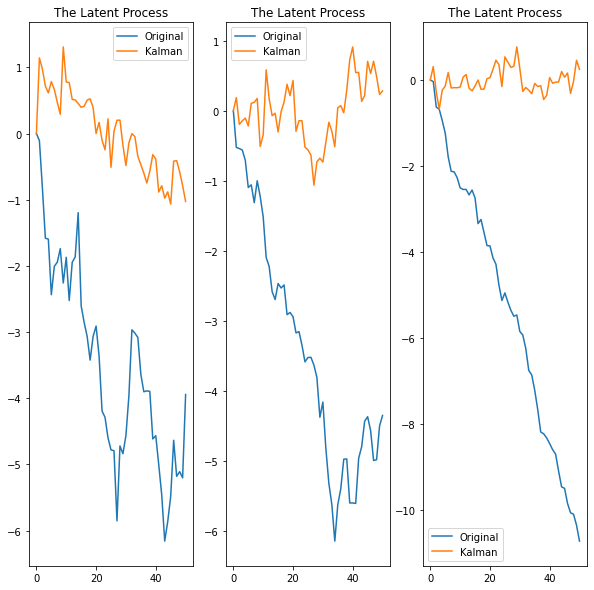

In [316]:
fig, ax = plt.subplots(1,3, figsize = (10, 10))
for j in range(x_multi_g.shape[1]):
    ax[j].plot(range(N+1), x_multi_g[:, j], label = 'Original')
    ax[j].plot(range(N+1), state_multi_g_test[:, j], label = 'Kalman')
    ax[j].set_title('The Latent Process')
    ax[j].legend()


The smoother is

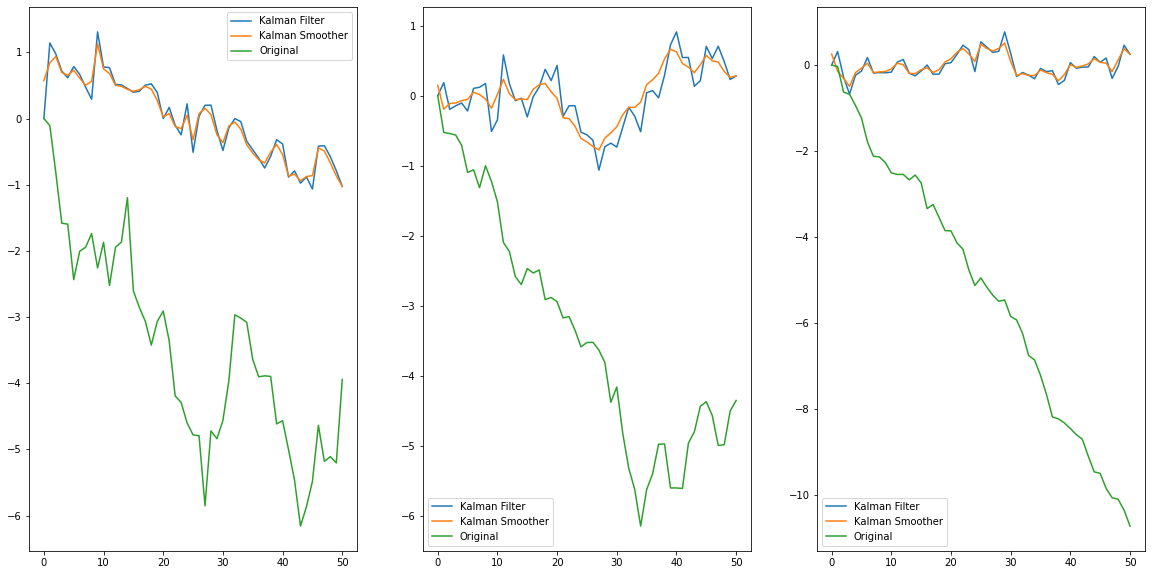

In [317]:
smooth_multi_g_test, smooth_cov_multi_g_tset = KalmanSmooth(state_multi_g_test, state_one_step_multi_g_test, state_cov_multi_g_test, state_cov_one_step_multi_g_test, np.identity(3), init_params['eta_init'], np.diag(init_params['w_init']))

fig, ax = plt.subplots(1,3, figsize = (20, 10))
for j in range(x_multi_g.shape[1]):
    ax[j].plot(range(N+1), state_multi_g_test[:, j], label = 'Kalman Filter')
    ax[j].plot(range(N+1), smooth_multi_g_test[:, j], label = 'Kalman Smoother')
    ax[j].plot(range(N+1), x_multi_g[:, j], label = 'Original')
    ax[j].legend()

In [152]:
G = np.identity(3)
B = init_params['eta_init']
W = np.diag(init_params['w_init'])


smooth_state = np.zeros((state_multi_g_test.shape[0], state_multi_g_test.shape[1]))
smooth_state_cov  = np.zeros((state_multi_g_test.shape[0], state_multi_g_test.shape[1], state_multi_g_test.shape[1]))
smooth_state_draws = np.zeros((state_multi_g_test.shape[0], state_multi_g_test.shape[1]))

smooth_state[-1] = state_multi_g_test[-1]
smooth_state_cov[-1] = state_cov_multi_g_test[-1]
smooth_state_draws[-1] = np.random.multivariate_normal(smooth_state[-1], smooth_state_cov[-1])

for i in reversed(range(1, state_multi_g_test.shape[0])): 

    R = np.dot(G, state_cov_multi_g_test[i]).dot(G.T) + W
    R = (1-0.2)*R + 0.2*2*np.identity(R.shape[0])
    print('R')
    print(np.linalg.cond(R))

    if R.ndim == 1:
        J = np.dot(state_cov_multi_g_test[i], G.T).dot(1/R)
    else:
        J = np.dot(state_cov_multi_g_test[i], G.T).dot(np.linalg.inv(R))

    smooth_state[i-1] = state_multi_g_test[i-1] + np.dot(J, smooth_state_draws[i] - B - state_one_step_multi_g_test[i-1])
    smooth_state_cov[i-1] = state_cov_multi_g_test[i-1] - np.dot(J, smooth_state_cov[i] - state_cov_one_step_multi_g_test[i-1]).dot(J.T)

    smooth_state_draws[i-1] = np.random.multivariate_normal(smooth_state[i-1], smooth_state_cov[i-1])

R
1.1890877663785093
R
1.189087766378509
R
1.189087766378509
R
1.189087766378509
R
1.1890877663785093
R
1.189087766378509
R
1.189087766378509
R
1.189087766378509
R
1.1890877663785093
R
1.1890877663785098
R
1.1890877663785093
R
1.189087766378509
R
1.189087766378509
R
1.189087766378509
R
1.1890877663785093
R
1.189087766378509
R
1.189087766378509
R
1.1890877663785095
R
1.1890877663785093
R
1.1890877663785095
R
1.189087766378509
R
1.189087766378509
R
1.1890877663785095
R
1.1890877663785093
R
1.1890877663785098
R
1.1890877663785095
R
1.1890877663785084
R
1.1890877663785044
R
1.1890877663784902
R
1.1890877663784323
R
1.1890877663782016
R
1.1890877663772792
R
1.1890877663736052
R
1.1890877663589587
R
1.18908776630057
R
1.1890877660677988
R
1.1890877651398077
R
1.189087761439981
R
1.1890877466876655
R
1.1890876878559866
R
1.1890874531701079
R
1.1890865165335007
R
1.1890827756533566
R
1.1890678227268374
R
1.1890080955521172
R
1.1887720966328765
R
1.187901593774735
R
1.1861205936961536
R
1.20549

In [541]:
group_membership = np.array(group_multi_g)
T = y_multi_g.shape[0]
N = 100

# Priors
beta_mean = init_params['beta_mean']
beta_var = init_params['beta_var']

alpha_mean = init_params['alpha_mean']
alpha_var = init_params['alpha_var']

eta_mean = init_params['eta_mean']
eta_var = init_params['eta_var']

v_alpha = init_params['v_alpha']
v_beta = init_params['v_beta']

w_alpha = init_params['w_alpha']
w_beta = init_params['w_beta']

# initial gibbs
beta_init = init_params['beta_init']
alpha_init = init_params['alpha_init']
eta_init = init_params['eta_init']
w_init = init_params['w_init']
v_init = init_params['v_init']

# init kalman
init_x = init_params['init_x']
init_c = init_params['init_c']



In [547]:
B_vec = np.zeros((N+1,1 + nr_groups_multi_g))
B_vec[0] = eta_init

R_conds = np.zeros((N,T,2))

w = np.zeros((N+1,1 + nr_groups_multi_g))
w[0] = w_init

beta_vec = np.zeros((N+1,2*nr_stocks_multi_g))
beta_vec[0] = beta_init

A_vec = np.zeros((N+1,nr_stocks_multi_g))
A_vec[0] = alpha_init

v = np.zeros((N+1, nr_stocks_multi_g))
v[0] = v_init

states_store = np.zeros((N, T, 1 + nr_groups_multi_g))

G = np.identity(1 + nr_groups_multi_g)


# index to help count
index = np.array(range(nr_stocks_multi_g))

# constraints
beta_vec[0, :nr_stocks_multi_g] = beta_vec[0, :nr_stocks_multi_g]/np.sum(np.abs(beta_vec[0, :nr_stocks_multi_g]))
for j in range(nr_groups_multi_g):
    beta_vec[0, nr_stocks_multi_g + index[group_membership == j]] = beta_vec[0, nr_stocks_multi_g + index[group_membership == j]]/np.sum(np.abs(beta_vec[0, nr_stocks_multi_g + index[group_membership == j]]))


In [548]:
for i in range(1,2):
    F = np.zeros((nr_stocks_multi_g,  1+ nr_groups_multi_g))
    F[:,0] = beta_vec[i-1, :nr_stocks_multi_g]
    for j in range(nr_stocks_multi_g):
        F[j,1 + group_membership[j]] = beta_vec[i-1,nr_stocks_multi_g + j]

    smooth_state = FFBS(y_multi_g, G, B_vec[i-1], np.diag(w[i-1]), F, A_vec[i-1],  np.diag(v[i-1]), init_x, init_c)

    # Constraint
    smooth_state_new = smooth_state[1:] - np.mean(smooth_state[1:] , axis = 0)
    # print(smooth_state_new.shape)
    states_store[i-1] = smooth_state_new

    # sample beta_i
    print('beta_i')
    for j in range(y_multi_g.shape[1]):
        var = 1.0 / ((np.sum(smooth_state_new[:,0] ** 2) / v[i-1,j]) + (1.0 / beta_var))
        tmp1 = y_multi_g[:,j]*smooth_state_new[:,0]
        tmp2 = A_vec[i-1, j]*smooth_state_new[:,0] 
        tmp3 = beta_vec[i-1, nr_stocks_multi_g + j]*smooth_state_new[:,0]*smooth_state_new[:,1 + group_membership[j]] 

        avg = ((beta_mean/beta_var) + (np.nansum(tmp1 - tmp2 -tmp3))/v[i-1,j]) * var
        beta_vec[i,j] = np.random.normal(avg, np.sqrt(var))
        print(beta_vec[i,j])

    # constraints
    beta_vec[i, :nr_stocks_multi_g] = beta_vec[i, :nr_stocks_multi_g]/np.sum(np.abs(beta_vec[i, :nr_stocks_multi_g]))

    # sample beta_g_i
    print('beta_s')
    for j in range(y_multi_g.shape[1]):
        var = 1.0 / ((np.sum(smooth_state_new[:,1 + group_membership[j]]  ** 2) / v[i-1,j]) + (1.0 / beta_var))
        tmp1 = y_multi_g[:,j]*smooth_state_new[:,1 + group_membership[j]] 
        tmp2 = A_vec[i-1, j]*smooth_state_new[:,1 + group_membership[j]] 
        tmp3 = beta_vec[i-1, j]*smooth_state_new[:,0]*smooth_state_new[:,1 + group_membership[j]] 

        avg = ((beta_mean/beta_var) + (np.nansum(tmp1 - tmp2 -tmp3))/v[i-1,j]) * var
        beta_vec[i,nr_stocks_multi_g + j] = np.random.normal(avg, np.sqrt(var))
        print(beta_vec[i,nr_stocks_multi_g + j])

    # constraints
    # beta_vec[i, n_stock:] = beta_vec[i, n_stock:]/np.sum(beta_vec[i, n_stock:])
    for j in range(nr_groups_multi_g):
        # print(index[group_membership == j])
        beta_vec[i, nr_stocks_multi_g + index[group_membership == j]] = beta_vec[i, nr_stocks_multi_g + index[group_membership == j]]/np.sum(np.abs(beta_vec[i, nr_stocks_multi_g + index[group_membership == 0]]))

    # sample alpha
    print('alpha')
    for j in range(nr_stocks_multi_g):
        var = 1.0 / ((y_multi_g.shape[0] / v[i-1,j]) + (1 / alpha_var[j]))
        avg = np.nansum(y_multi_g[:, j] - beta_vec[i,j]*smooth_state_new[:, 0] - beta_vec[i,nr_stocks_multi_g + j]*smooth_state_new[:,1 + group_membership[j]]  )/v[i-1,j]
        avg += alpha_mean[j]/alpha_var[j]
        avg *= var
        A_vec[i,j] = np.random.normal(avg, np.sqrt(var))
        print(A_vec[i,j])

    # sample variance of observation
    print('v')
    for j in range(nr_stocks_multi_g):
        alpha = (y_multi_g.shape[0]/2.0) + v_alpha
        beta = 0.5 * np.nansum((y_multi_g[:,j] - A_vec[i,j] - beta_vec[i,j]*smooth_state_new[:, 0] - beta_vec[i,nr_stocks_multi_g + j]*smooth_state_new[:,1 + group_membership[j]]  ) ** 2) + v_beta
        v[i,j] = invgamma.rvs(a = alpha, loc = 0, scale = beta)
        print(v[i,j])


    # state equations
    print('eta')
    for j in range(1 + nr_groups_multi_g):
        var = 1.0 / ((y_multi_g.shape[0] / w[i-1,0]) + (1.0 / eta_var[j]))
        avg = np.nansum(smooth_state_new[1:, j] - smooth_state_new[:(smooth_state_new.shape[0]-1), j]) / w[i-1,j]
        avg += (eta_mean[j]/eta_var[j])
        avg *= var
        B_vec[i,j] = np.random.normal(avg, np.sqrt(var))
        print(B_vec[i,j])

    print('w')
    for j in range(1 + nr_groups_multi_g):
        alpha_w_tmp = y_multi_g.shape[0]/2.0 + w_alpha
        beta_w_tmp = 0.5 * np.nansum((smooth_state_new[1:,j] - smooth_state_new[:(smooth_state_new.shape[0]-1),j] - B_vec[i, j]) ** 2) + w_beta
        w[i,j] = invgamma.rvs(a = alpha_w_tmp, loc = 0, scale = beta_w_tmp)
        print(w[i,j])
        assert w[i,j] < 10000

beta_i
-0.09231094533142281
0.1650545480332108
0.0973773806902252
0.03283020973217846
-0.10427434715226722
-0.18084418091990614
-0.14154707148796852
0.09999615420302867
0.01898172614554729
-0.03632847990222236
beta_s
-0.2340514106881
0.2597913142433702
0.24059247938231557
-0.18509497564289437
-0.16729385237285083
-0.4022613175259188
-0.2119891369781944
0.11124818609028908
0.05528585541730553
-0.1765489586348467
alpha
60.202036202930124
40.80230618822901
46.83397014382017
51.67803767855264
56.02674203467506
66.39433605166354
48.41183780250002
54.255438758188745
57.73246228724099
41.73599276956432
v
0.45132843100077386
0.6190202284237938
0.20126359979015754
0.35554636596335987
0.46740394701160837
0.5807987499131625
0.5466020981270251
0.37630060186147585
0.2975287582950944
0.24376656466815128
eta
-0.41134608930752237
-0.11963675698195533
0.23841761048671647
w
3.273427314451074
2.0950373679426346
1.712415108447444


In [554]:
np.sqrt(var)

0.03128412265167023

In [359]:
np.nansum((y_multi_g[:,j] - A_vec[i,j] - beta_vec[i,j]*smooth_state_new[:, 0] - beta_vec[i,nr_stocks_multi_g + j]*smooth_state_new[:,1 + group_membership[j]]  ) ** 2) / 50

6.510135755605271

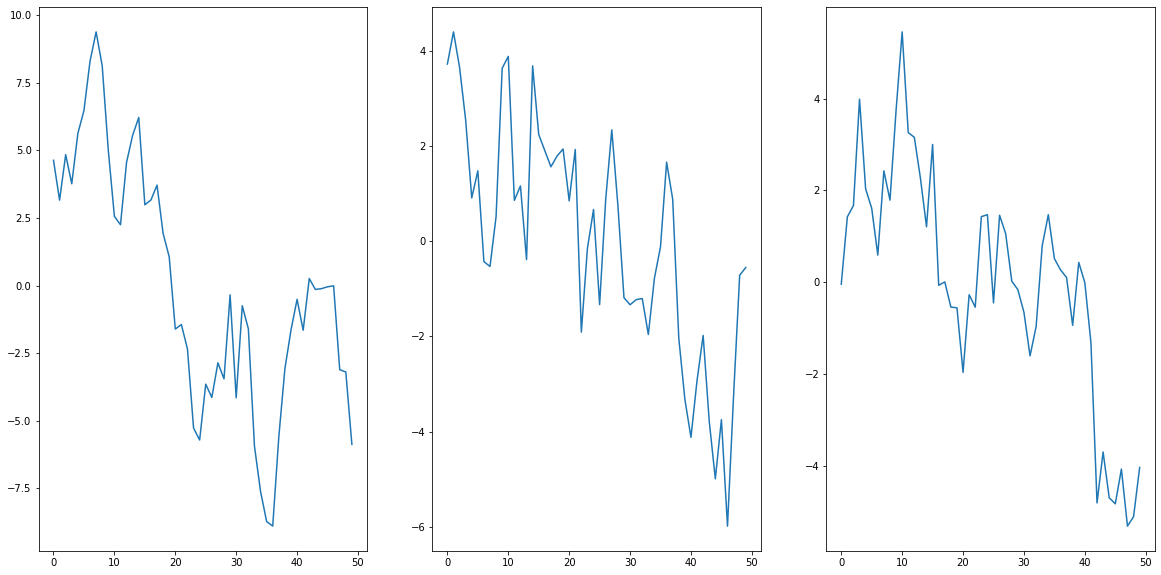

In [558]:
fig, ax = plt.subplots(1,3, figsize = (20, 10))
for j in range(smooth_state_new.shape[1]):
    ax[j].plot(range(smooth_state_new.shape[0]), smooth_state_new[:, j], label = 'Kalman Filter')


Let's see what the filter is doing

In [565]:
np.diag(w[i-1])

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

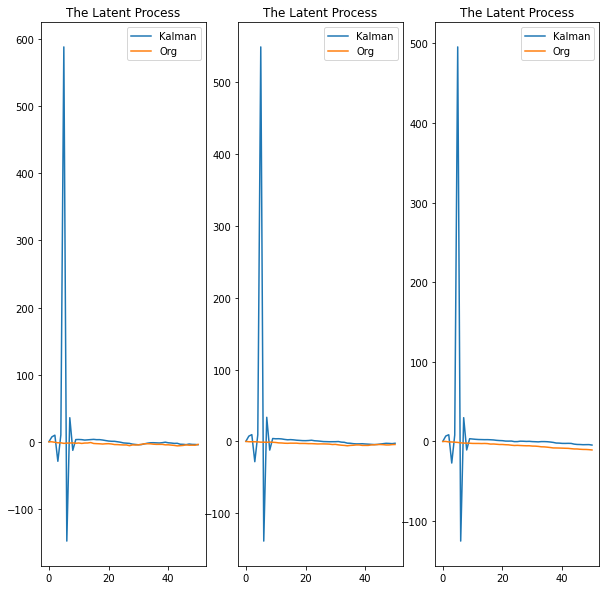

In [590]:
i = 1
init_x = np.array([0, 0, 0])
init_c = np.array([10, 10, 10])

(state_test, 
state_cov_test, 
state_one_step_test, 
state_cov_one_step_test, 
R_inv_test,
y_est_test, 
error_test,
neglik_test, R_cond) = KalmanFilter(y_multi_g, G, B_vec[i-1], np.diag(w[i-1]), F, A_vec[i-1],  np.diag(v[i-1]), init_x, init_c)

fig, ax = plt.subplots(1,3, figsize = (10, 10))
for j in range(state_test.shape[1]):
    ax[j].plot(range(state_test.shape[0]), state_test[:, j], label = 'Kalman')
    ax[j].plot(range(state_test.shape[0]), x_multi_g[:, j], label = 'Org')
    ax[j].set_title('The Latent Process')
    ax[j].legend()

# GIBBS MULITU

In [626]:
w_gibbs_multi_g, v_gibbs_multi_g, beta_gibbs_multi_g, A_gibbs_multi_g, B_gibbs_multi_g, states_gibbs_multi_g, R_cond_multi_g = gibbs_group(5000, y_multi_g, np.array(group_multi_g), init_params, verbose = True)

T 50, n_stock 10, n_groups 2






C:\Users\ragna\AppData\Local\Temp/ipykernel_8948/1415575845.py:133: RuntimeWarning: covariance is not positive-semidefinite.
  smooth_state_draws[i-1] = np.random.multivariate_normal(smooth_state[i-1], smooth_state_cov[i-1])
C:\Users\ragna\AppData\Local\Temp/ipykernel_8948/1415575845.py:118: RuntimeWarning: covariance is not positive-semidefinite.
  smooth_state_draws[-1] = np.random.multivariate_normal(smooth_state[-1], smooth_state_cov[-1])







































































































































































































































































































































































































































































































































































[58.35558684 44.18481582 48.76433946 50.9908553  53.68209953 63.55527884
 45.99021346 55.42703315 57.77243707 41.39351238]


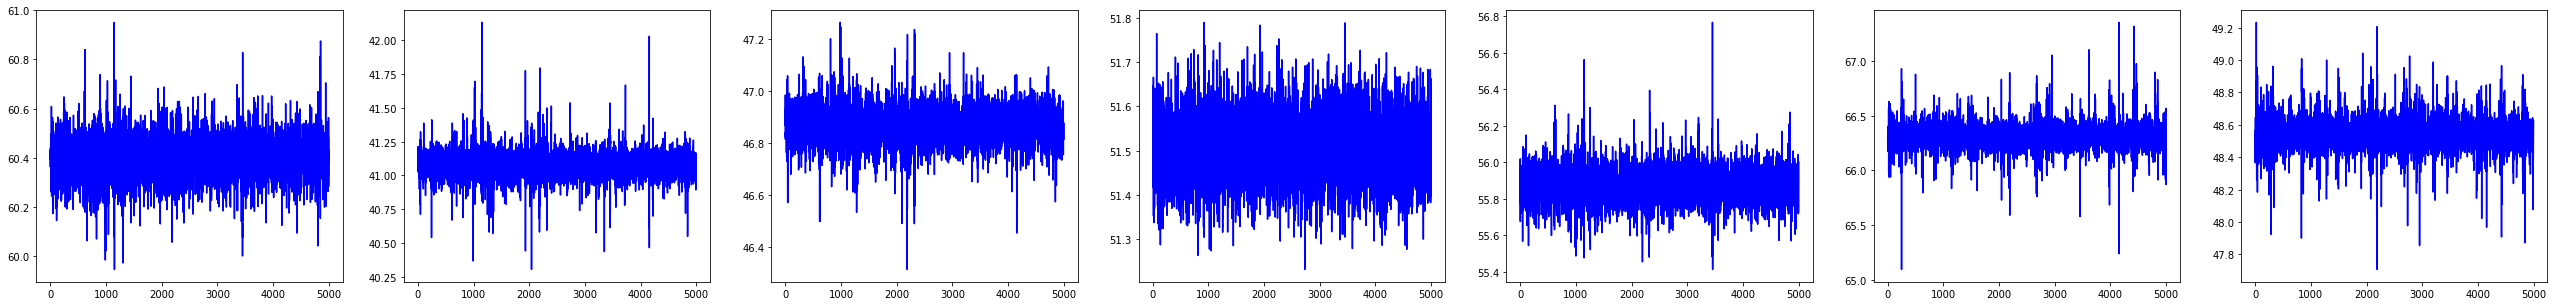

In [627]:
print(a_multi_g)
fig, ax = plt.subplots(1,len(a_multi), figsize = (45,5))
for j in range(len(a_multi)):
    ax[j].plot(range(A_gibbs_multi_g.shape[0]),A_gibbs_multi_g[:,j], color='b')


[-0.12545988  0.45071431  0.23199394  0.09865848 -0.34398136 -0.34400548
 -0.44191639  0.36617615  0.10111501  0.20807258]
[-0.47941551  0.46990985  0.33244264 -0.28766089 -0.31817503 -0.31659549
 -0.19575776  0.02475643 -0.06805498 -0.20877086]


  0%|          | 0/5000 [09:22<?, ?it/s]


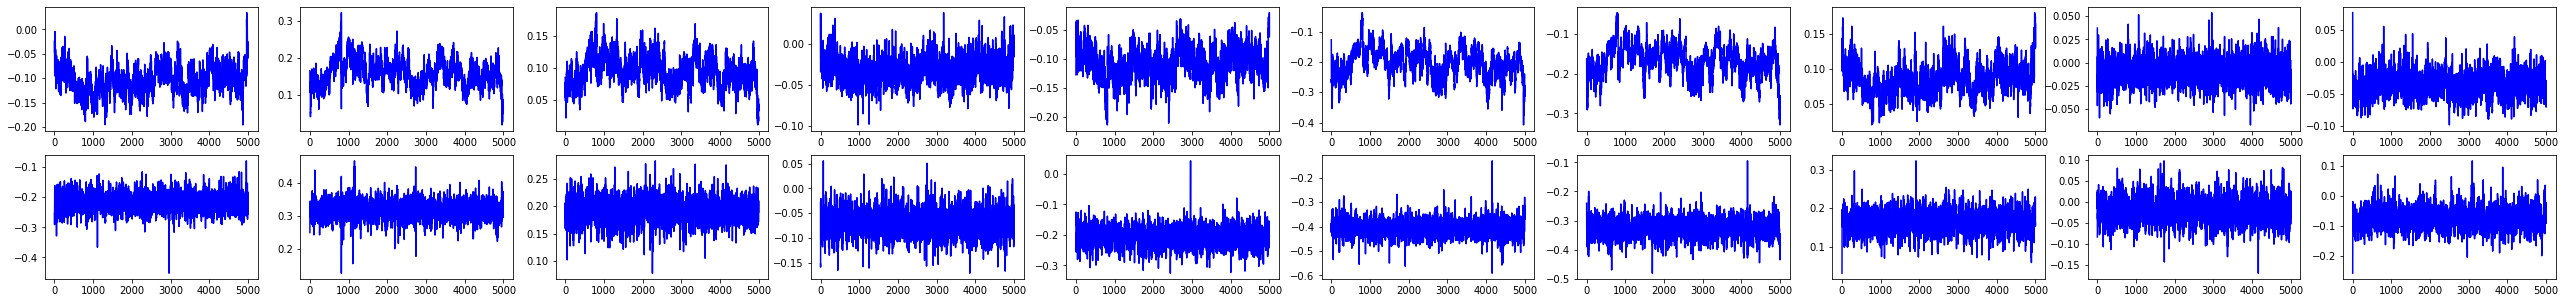

In [628]:
print(beta_multi_g)
fig, ax = plt.subplots(2,len(a_multi_g), figsize = (45,5))
for j in range(len(a_multi_g)):
    ax[0,j].plot(range(beta_gibbs_multi_g.shape[0]),beta_gibbs_multi_g[:,j], color='b')
print(beta_s_multi_g)
for j in range(len(a_multi_g)):
    ax[1,j].plot(range(beta_gibbs_multi_g.shape[0]),beta_gibbs_multi_g[:,nr_stocks_multi_g + j], color='b')

[0.38226346 0.25115724 0.21951548 0.48466566 0.48968961 0.4425192
 0.29138413 0.22930163 0.40526991 0.33204575]


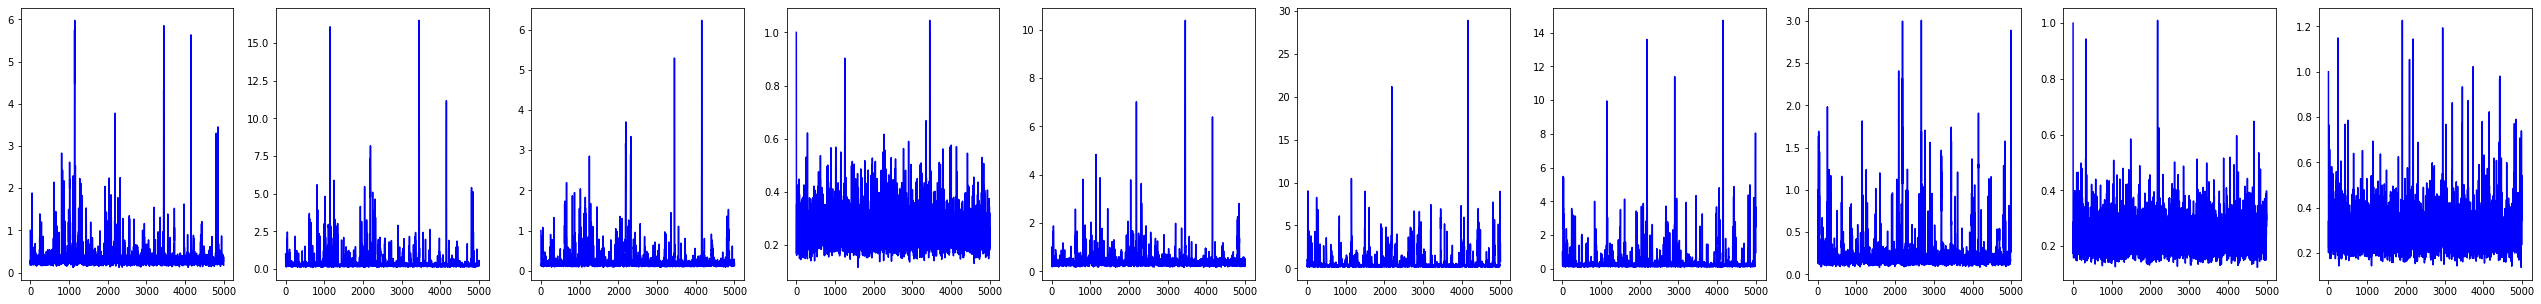

In [629]:
print(v_multi_g)
fig, ax = plt.subplots(1,len(v_multi_g), figsize = (45,5))
for j in range(len(v_multi_g)):
    ax[j].plot(range(v_gibbs_multi_g.shape[0]),v_gibbs_multi_g[:,j], color='b')


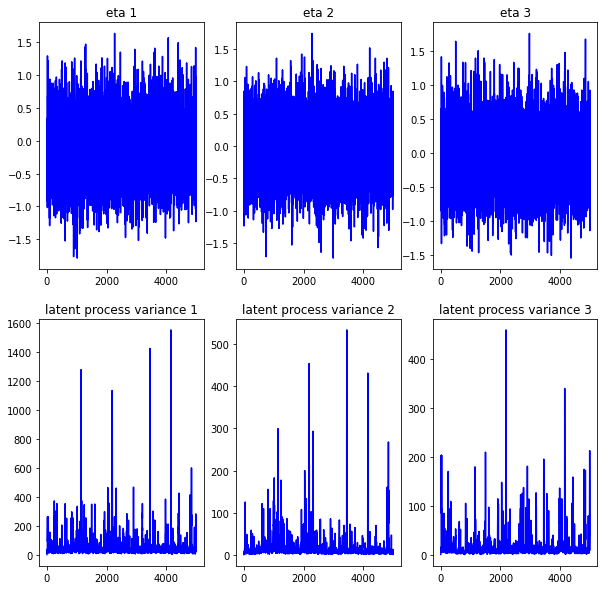

In [630]:
fig, ax = plt.subplots(2,3, figsize = (10,10))
for j in range(3):
        ax[0,j].plot(range(B_gibbs_multi_g.shape[0]),B_gibbs_multi_g[:,j], color='b')
        ax[0,j].set_title(f'eta {j+1}')
        ax[1,j].plot(range(w_gibbs_multi_g.shape[0]),w_gibbs_multi_g[:,j], color='b')
        ax[1,j].set_title(f'latent process variance {j+1}')


Text(0.5, 1.0, 'Latent processes')

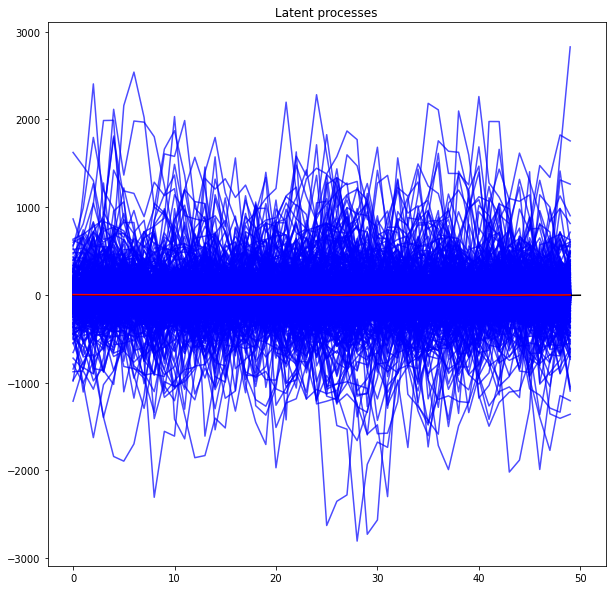

In [600]:
plt.figure(figsize=(10,10))
for i in range(3000):
    plt.plot(range(states_gibbs_multi_g.shape[1]), states_gibbs_multi_g[i, :, 0], color = 'blue', alpha = 0.7, label = 'FFBS')

plt.plot(range(x_multi_g.shape[0]), x_multi_g[:,0], color = 'black', label = 'original')

x_multi_g_constrained = x_multi_g[1:] - np.mean(x_multi_g[1:] , axis = 0)
plt.plot(range(x_multi_g_constrained.shape[0]), x_multi_g_constrained[:,0], color = 'red', label = 'original Constraint')

#plt.legend()
plt.title("Latent processes")

In [662]:
w_gibbs_multi_g[7]

array([17.23126645,  5.93086307,  8.15176791])

In [652]:
R_cond_multi_g[10,:]

array([[56.42071349,  0.        ],
       [55.23095472,  0.        ],
       [55.14068381,  0.        ],
       [55.09146086,  0.        ],
       [55.06456962,  0.        ],
       [55.04996792,  0.        ],
       [55.04206029,  0.        ],
       [55.03778321,  0.        ],
       [55.03547126,  0.        ],
       [55.03422197,  0.        ],
       [55.03354701,  0.        ],
       [55.03318238,  0.        ],
       [55.03298541,  0.        ],
       [55.03287901,  0.        ],
       [55.03282154,  0.        ],
       [55.03279049,  0.        ],
       [55.03277373,  0.        ],
       [55.03276467,  0.        ],
       [55.03275977,  0.        ],
       [55.03275713,  0.        ],
       [55.0327557 ,  0.        ],
       [55.03275493,  0.        ],
       [55.03275452,  0.        ],
       [55.03275429,  0.        ],
       [55.03275417,  0.        ],
       [55.0327541 ,  0.        ],
       [55.03275407,  0.        ],
       [55.03275405,  0.        ],
       [55.03275404,

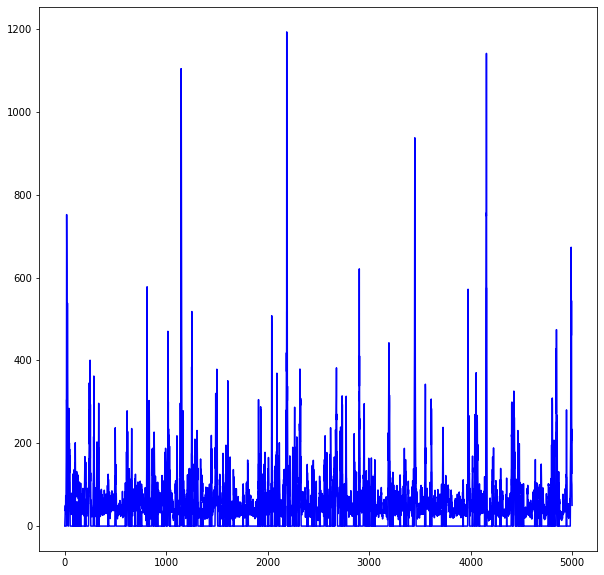

In [641]:
fig, ax = plt.subplots(1,1, figsize = (10,10))
ax.plot(range(R_cond_multi_g.shape[0]),np.max(R_cond_multi_g,axis = 1), color='b')

Regularize